# Assignment 1 - Task 2 & 3

# Task 2

In [149]:
import json
from pathlib import Path
from datetime import datetime
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import scatter_matrix
import seaborn as sns
import numpy as np
%matplotlib inline

In [479]:
state_names = ["California", "Florida", "Illinois", "Minnesota"]
state_ids = {"California":"CA", "Florida":"FL", "Illinois":"IL", "Minnesota":"MN"}
sector_names = ["Overall", "Industrial", "Residential", "Commercial"]
sector_names = {"Overall":"ALL", "Industrial":"IND", "Residential":"RES", "Commercial":"COM"}

In [151]:
state_colors = {"California":"orange", "Florida":"darkred", "Illinois":"green", "Minnesota":"navy"}
fontsize = 13

Assign the directory to raw data and clean pre-processed data and make sure it exists

In [152]:
dir_raw = Path("raw4")
dir_data = Path("data4")
dir_data.mkdir(parents=True, exist_ok=True)

## Data Preprocessing
Create a dictionary "state_files" to store the directory for each file we would like to read later

In [153]:
state_files = {}
for state_id in state_ids.values():
    state_files[state_id] = []

In [154]:
for fpath in dir_raw.iterdir():
    if fpath.suffix == ".json":
        # parse the filename
        parts = fpath.stem.split(".")
        if parts[0] in state_ids.values():
            state_files[parts[0]] = fpath            

### Data Parsing and Merging
Define a function that reads the json file and makes the wanted data show in data frame

In [155]:
def parse_raw_data_bySectorID(state_name, fpath, sectorID):
    fin = open(fpath, "r")
    jdata = fin.read()
    data = json.loads(jdata)
    rows = []
    for i in data['response']['data']:
        if i['sectorid'] == sectorID:
            row = {"State": state_name}
            row['SectorID'] = i['sectorid']
            row['Period'] = datetime.strptime(i['period'], '%Y-%m')
            row['Price'] = i['price']
            row['Revenue'] = i['revenue']
            row['Sales'] = i['sales']
            rows.append(row)
    fin.close()
    return pd.DataFrame(rows)

Merge the raw data for each state and store it into the dictionary "df_states" in data frame style, so we can access the data easily later on.

In [156]:
def parse_data_bySectorID(sectorID):
    df_states = {}
    df_files = []
    for state_name in state_ids:
        for fpath in state_files.values():
            f = fpath.stem.split(".")[0]
            if (state_ids[state_name] == f):
                df_file = parse_raw_data_bySectorID(state_name, fpath, sectorID)
                df_files.append(df_file)
                df_state = pd.concat(df_files)
                df_state.drop_duplicates(subset="Period" , keep = "last", inplace=True)
                df_state.set_index("Period", inplace=True)
                d = df_state.sort_index()
                df_states[state_name] = d
    return df_states

Also one data frame to store all data together.

In [406]:
def parse_raw_data(state_name, fpath):
    fin = open(fpath, "r")
    jdata = fin.read()
    data = json.loads(jdata)
    rows = []
    for i in data['response']['data']:
        if i['sectorid'] != 'TRA' and i['sectorid'] != 'OTH':
            row = {"State": state_name}
            row['SectorID'] = i['sectorid']
            row['Period'] = datetime.strptime(i['period'], '%Y-%m')
            row['Price'] = i['price']
            row['Revenue'] = i['revenue']
            row['Sales'] = i['sales']
            rows.append(row)
    fin.close()
    return pd.DataFrame(rows)

In [408]:
df_sectors = {}
df_files = []
for state_name in state_ids:
    for fpath in state_files.values():
        f = fpath.stem.split(".")[0]
        if (state_ids[state_name] == f):
            df_file = parse_raw_data(state_name, fpath)
            df_files.append(df_file)
            df_sector = pd.concat(df_files)
            df_sector.drop_duplicates(subset=["Period", "SectorID"] , keep = "last", inplace=True)
            df_sector.set_index("Period", inplace=True)
            d = df_sector.sort_index()
            df_sectors[state_name] = d

We'll have 4 different data frames, each represent different sectors.<br />
- ALL = all sectors(Overall)
- IND = Industrial
- RES = Residential
- COM = Commercial

In [157]:
df_states_ALL = parse_data_bySectorID("ALL")
df_states_IND = parse_data_bySectorID("IND")
df_states_RES = parse_data_bySectorID("RES")
df_states_COM = parse_data_bySectorID("COM")

In [409]:
df_states_ALL

{'California':                  State SectorID  Price     Revenue        Sales
 Period                                                         
 2006-01-01  California      ALL  11.25  2354.82896  20936.25593
 2006-02-01  California      ALL  11.72  2227.63111  19005.52089
 2006-03-01  California      ALL  11.69  2497.12385  21352.85350
 2006-04-01  California      ALL  12.04  2192.42866  18203.52845
 2006-05-01  California      ALL  12.31  2534.13849  20582.28385
 ...                ...      ...    ...         ...          ...
 2021-08-01  California      ALL  21.28  5532.73557  26005.66433
 2021-09-01  California      ALL  21.48  5070.57656  23607.68684
 2021-10-01  California      ALL  19.87  4100.48088  20641.27103
 2021-11-01  California      ALL  18.88  3540.14563  18754.52085
 2021-12-01  California      ALL  19.41  3896.05659  20077.35605
 
 [192 rows x 5 columns],
 'Florida':               State SectorID  Price     Revenue        Sales
 Period                                  

In [411]:
df_sectors

{'California':                  State SectorID  Price     Revenue        Sales
 Period                                                         
 2006-01-01  California      ALL  11.25  2354.82896  20936.25593
 2006-01-01  California      RES  13.14  1001.84192   7625.96523
 2006-01-01  California      IND   9.13   367.20257   4021.70704
 2006-01-01  California      COM  10.65   981.88164   9215.50066
 2006-02-01  California      ALL  11.72  2227.63111  19005.52089
 ...                ...      ...    ...         ...          ...
 2021-11-01  California      ALL  18.88  3540.14563  18754.52085
 2021-12-01  California      ALL  19.41  3896.05659  20077.35605
 2021-12-01  California      COM  18.37  1686.79576   9184.34678
 2021-12-01  California      IND  13.79   476.60507   3455.97844
 2021-12-01  California      RES  23.38  1725.99458   7382.76737
 
 [768 rows x 5 columns],
 'Florida':               State SectorID  Price     Revenue        Sales
 Period                                  

### Data Verification
Check if the data in data frames are correct

In [158]:
df_states_ALL['California'].head(2)

State SectorID  Price     Revenue        Sales
Period                                                         
2006-01-01  California      ALL  11.25  2354.82896  20936.25593
2006-02-01  California      ALL  11.72  2227.63111  19005.52089

In [160]:
df_states_RES['Illinois'].head(2)

State SectorID  Price    Revenue       Sales
Period                                                     
2006-01-01  Illinois      RES   7.43  305.88169  4116.69592
2006-02-01  Illinois      RES   7.93  288.81005  3643.33807

In [161]:
df_states_IND['Minnesota'].head(2)

State SectorID  Price   Revenue       Sales
Period                                                     
2006-01-01  Minnesota      IND   4.85  90.36784  1864.60651
2006-02-01  Minnesota      IND   5.04  89.86931  1782.91206

In [162]:
df_states_COM['Florida'].head(2)

State SectorID  Price    Revenue       Sales
Period                                                    
2006-01-01  Florida      COM   9.71  671.49440  6912.26119
2006-02-01  Florida      COM  10.00  647.01221  6472.06385

In [412]:
df_sectors['Florida'].head(10)

State SectorID  Price     Revenue        Sales
Period                                                      
2006-01-01  Florida      ALL  10.21  1810.41056  17735.76105
2006-01-01  Florida      RES  11.04  1026.65140   9299.39200
2006-01-01  Florida      IND   7.35   111.38968   1515.46921
2006-01-01  Florida      COM   9.71   671.49440   6912.26119
2006-02-01  Florida      ALL  10.34  1670.10111  16158.92560
2006-02-01  Florida      RES  11.15   903.58630   8101.34728
2006-02-01  Florida      IND   7.52   118.64251   1577.15081
2006-02-01  Florida      COM  10.00   647.01221   6472.06385
2006-03-01  Florida      ALL  10.35  1645.45462  15893.04189
2006-03-01  Florida      RES  11.20   865.90844   7728.90921

Check the number of rows and year ranges in the DataFrames. First, we have to summerize the dates for each dataframe.

In [163]:
def summarize_dates_byDF(df_states):
    rows = []
    for state_name in state_names:
        row = {"State": state_name}
        row["Rows"] = len(df_states[state_name])
        row["DateStart"] = df_states[state_name].index.min()
        row["DateEnd"] = df_states[state_name].index.max()
        rows.append(row)
    return pd.DataFrame(rows).set_index("State")

In [413]:
df_ALL = summarize_dates_byDF(df_states_ALL)
df_RES = summarize_dates_byDF(df_states_RES)
df_COM = summarize_dates_byDF(df_states_COM)
df_IND = summarize_dates_byDF(df_states_IND)
df_sec = summarize_dates_byDF(df_sectors)

In [414]:
df_sec

Rows  DateStart    DateEnd
State                                 
California   768 2006-01-01 2021-12-01
Florida      768 2006-01-01 2021-12-01
Illinois     768 2006-01-01 2021-12-01
Minnesota    768 2006-01-01 2021-12-01

In [165]:
df_ALL

Rows  DateStart    DateEnd
State                                 
California   192 2006-01-01 2021-12-01
Florida      192 2006-01-01 2021-12-01
Illinois     192 2006-01-01 2021-12-01
Minnesota    192 2006-01-01 2021-12-01

In [372]:
df_IND

Rows  DateStart    DateEnd
State                                 
California   192 2006-01-01 2021-12-01
Florida      192 2006-01-01 2021-12-01
Illinois     192 2006-01-01 2021-12-01
Minnesota    192 2006-01-01 2021-12-01

In [373]:
df_RES

Rows  DateStart    DateEnd
State                                 
California   192 2006-01-01 2021-12-01
Florida      192 2006-01-01 2021-12-01
Illinois     192 2006-01-01 2021-12-01
Minnesota    192 2006-01-01 2021-12-01

In [374]:
df_COM

Rows  DateStart    DateEnd
State                                 
California   192 2006-01-01 2021-12-01
Florida      192 2006-01-01 2021-12-01
Illinois     192 2006-01-01 2021-12-01
Minnesota    192 2006-01-01 2021-12-01

Check if there's missing value for each df

In [388]:
def check_null(df_states):
    for state_name in state_names:
        print("%s: " % state_name)
        missing_counts = df_states[state_name].isnull().sum()
        # which coludmns have missing values?
        missing_counts = missing_counts[missing_counts > 0]
        if len(missing_counts) == 0:
            print("\t No missing values found")
        else:
            print(missing_counts)

In [389]:
check_null(df_states_ALL)

California: 
	 No missing values found
Florida: 
	 No missing values found
Illinois: 
	 No missing values found
Minnesota: 
	 No missing values found


In [390]:
check_null(df_states_RES)

California: 
	 No missing values found
Florida: 
	 No missing values found
Illinois: 
	 No missing values found
Minnesota: 
	 No missing values found


In [391]:
check_null(df_states_IND)

California: 
	 No missing values found
Florida: 
	 No missing values found
Illinois: 
	 No missing values found
Minnesota: 
	 No missing values found


In [392]:
check_null(df_states_COM)

California: 
	 No missing values found
Florida: 
	 No missing values found
Illinois: 
	 No missing values found
Minnesota: 
	 No missing values found


In [415]:
check_null(df_sectors)

California: 
	 No missing values found
Florida: 
	 No missing values found
Illinois: 
	 No missing values found
Minnesota: 
	 No missing values found


### Data Saving
Write the clean data in data frames into JSON file with coresponding state name.

In [169]:
for state_name in state_names:
    fname = "%s.json" % state_name
    out_path = dir_data / fname
    print("Writing %s" % out_path)
    df_states[state_name].to_json(out_path, orient="index", indent=4)

Writing data4/California.json
Writing data4/Florida.json
Writing data4/Illinois.json
Writing data4/Minnesota.json


## Data Analysis
### Data Loading

In [170]:
def load(df_states):
    print(df_states)
    df_states = {}
    for state_name in state_names:
        fname = "%s.json" % state_name
        in_path = dir_data / fname
        df_states[state_name] = pd.read_json(in_path, orient="index")

        print("%s: %d rows of data - [%s to %s]" % 
              (state_name, len(df_states[state_name]), 
               df_states[state_name].index.min(), df_states[state_name].index.max() ))
    print('\n')

In [418]:
df = ['df_states_ALL', 'df_states_IND', 'df_states_RES', 'df_states_COM']
for i in df:
    load(i)

df_states_ALL
California: 192 rows of data - [2006-01-01 00:00:00 to 2021-12-01 00:00:00]
Florida: 192 rows of data - [2006-01-01 00:00:00 to 2021-12-01 00:00:00]
Illinois: 192 rows of data - [2006-01-01 00:00:00 to 2021-12-01 00:00:00]
Minnesota: 192 rows of data - [2006-01-01 00:00:00 to 2021-12-01 00:00:00]


df_states_IND
California: 192 rows of data - [2006-01-01 00:00:00 to 2021-12-01 00:00:00]
Florida: 192 rows of data - [2006-01-01 00:00:00 to 2021-12-01 00:00:00]
Illinois: 192 rows of data - [2006-01-01 00:00:00 to 2021-12-01 00:00:00]
Minnesota: 192 rows of data - [2006-01-01 00:00:00 to 2021-12-01 00:00:00]


df_states_RES
California: 192 rows of data - [2006-01-01 00:00:00 to 2021-12-01 00:00:00]
Florida: 192 rows of data - [2006-01-01 00:00:00 to 2021-12-01 00:00:00]
Illinois: 192 rows of data - [2006-01-01 00:00:00 to 2021-12-01 00:00:00]
Minnesota: 192 rows of data - [2006-01-01 00:00:00 to 2021-12-01 00:00:00]


df_states_COM
California: 192 rows of data - [2006-01-01 0

In [174]:
df_states_RES['Minnesota'].head(10)

State SectorID  Price    Revenue       Sales
Period                                                      
2006-01-01  Minnesota      RES   8.12  161.52262  1988.38591
2006-02-01  Minnesota      RES   8.33  145.58415  1747.19657
2006-03-01  Minnesota      RES   7.98  138.50731  1736.05200
2006-04-01  Minnesota      RES   8.38  123.37006  1472.81399
2006-05-01  Minnesota      RES   8.81  130.33328  1479.71633
2006-06-01  Minnesota      RES   9.26  168.03155  1815.34407
2006-07-01  Minnesota      RES   9.45  240.75169  2546.37751
2006-08-01  Minnesota      RES   9.16  210.13882  2294.55562
2006-09-01  Minnesota      RES   8.70  149.71488  1721.60049
2006-10-01  Minnesota      RES   8.90  140.82139  1581.78312

## Functions Preperation

Define a function to get the basic statistics of specific column in each state from different data frame.

In [175]:
def compute_stats(df_states, col_name):
    rows = []
    for state_name in state_names:
        row = {"State": state_name}
        row["Min"] = df_states[state_name][col_name].min()
        row["Max"] = df_states[state_name][col_name].max()
        row["Mean"] = df_states[state_name][col_name].mean()
        row["Median"] = df_states[state_name][col_name].median()
        row["STD"] = df_states[state_name][col_name].std()
        rows.append(row)
    return pd.DataFrame(rows).set_index("State")

set all these, we'll use them later on

In [419]:
df_ALL_Price = compute_stats(df_states_ALL, "Price")
df_RES_Price = compute_stats(df_states_RES, "Price")
df_IND_Price = compute_stats(df_states_IND, "Price")
df_COM_Price = compute_stats(df_states_COM, "Price")
df_Price = compute_stats(df_sectors, "Price")

In [421]:
df_ALL_Sales = compute_stats(df_states_ALL, "Sales")
df_RES_Sales = compute_stats(df_states_RES, "Sales")
df_IND_Sales = compute_stats(df_states_IND, "Sales")
df_COM_Sales = compute_stats(df_states_COM, "Sales")
df_Sales = compute_stats(df_sectors, "Sales")

In [422]:
df_ALL_Rev = compute_stats(df_states_ALL, "Revenue")
df_RES_Rev = compute_stats(df_states_RES, "Revenue")
df_IND_Rev = compute_stats(df_states_IND, "Revenue")
df_COM_Rev = compute_stats(df_states_COM, "Revenue")
df_Rev = compute_stats(df_sectors, "Revenue")

### Line graph
Define a "line" function to draw a line graph for all 4 dataset(states), we can define which data frame and variable  we're going to use and speculate.

In [259]:
def line(df_states, df_stats, variable , sector):
    fig = plt.figure(figsize=(16,7.5))

    for i, state_name in enumerate(state_names):
        axc = fig.add_subplot(2, 2, i+1)
        ax = df_states[state_name][variable].plot(ax = axc, lw = 1.5, color = state_colors[state_name])
        
        ax.set_title(" %s Electricity %s in %s" % (sector, variable, state_name))
        ax.set_xlabel("Year")
        ax.set_ylabel("%s (USD)" % variable)

        ax.set_xlim(df_states[state_name].index.min(), df_states[state_name].index.max())
        ax.set_ylim(df_stats["Min"].min()*0.80 , df_stats["Max"].max()*1.2 ) 

    # fix the spacing between plots
    fig.tight_layout()

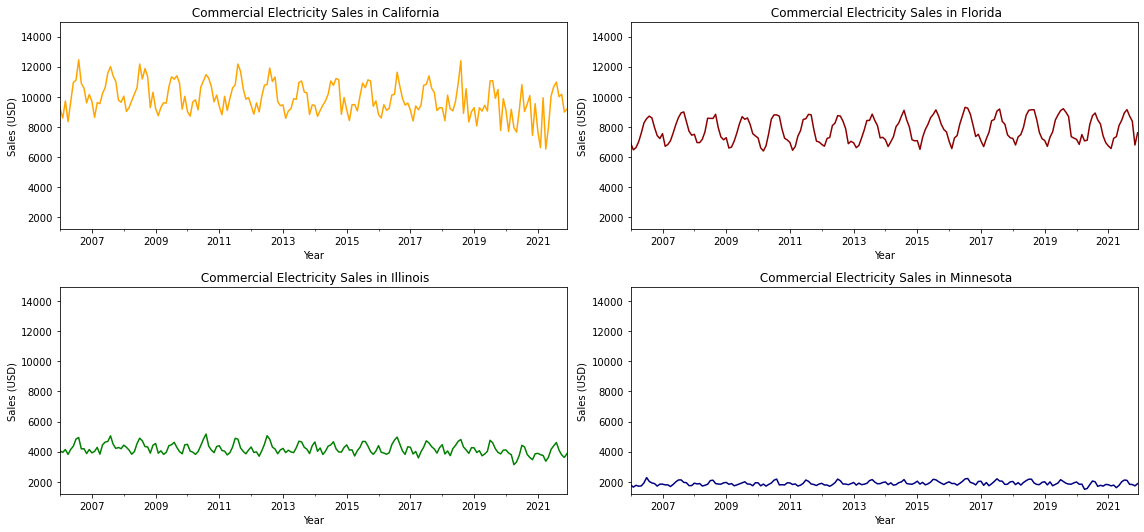

In [260]:
line(df_states_COM, df_COM_Sales, 'Sales', 'Commercial')

### Merge data by time period
Define a function to draw the highest and lowest value in our data. First, we don't need to know it monthly, so we group the data to yearly first. Then define another function to draw bar graph base on the data we just merged.

In [195]:
def yearly_range(df_states, variable):
    df_yearly_variable = {}
    for state_name in state_names:
        # groupy each index by year
        groups = df_states[state_name][variable].groupby(pd.Grouper(freq='Y'))
        min_variable = groups.min()
        max_variable = groups.max()
        # combine the min and max monthly values into a new DataFrame
        df_yearly_variable[state_name] = pd.DataFrame({"Min": min_variable, "Max": max_variable})
    return df_yearly_variable

### Bar graph

In [338]:
def yearly_range_bar(df_states, df_stats, variable, sector):
    fig = plt.figure(figsize=(14,7.5))
    df_yearly_range = yearly_range(df_states, variable)
    
    for i, state_name in enumerate(state_names):
    
        axc = fig.add_subplot(2, 2, i+1)
        ax = df_yearly_range[state_name].plot.bar(ax=axc, y=['Min', 'Max'], 
            color={ "Min": "royalblue", "Max": "firebrick"}, fontsize=fontsize, zorder=3)

        # generate nicer x-axis labels
        ax.set_title("%s Yearly %s Range in %s" % (sector, variable, state_name))
        ticklabels = [d.strftime("%Y") for d in df_yearly_range[state_name].index]
        ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
        ax.set_ylabel("Price (USD)")
        # again make the y-axis ranges consistent
        ax.set_ylim(0, df_stats["Max"].max()*1.1)
        ax.yaxis.grid(True);    
    # fix the spacing between plots
    fig.tight_layout()

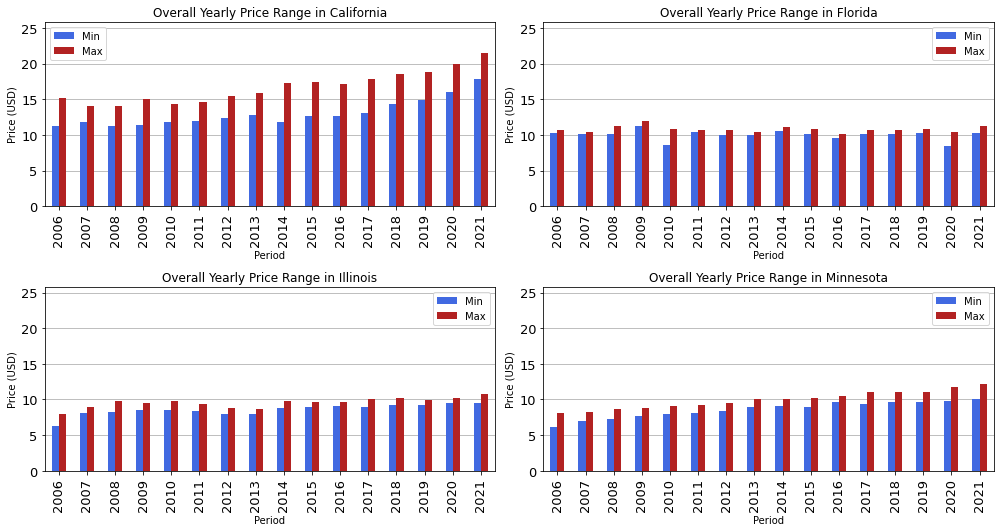

In [336]:
yearly_range_bar(df_states_ALL, df_ALL_Price, "Price", "Overall")

### Merge data by variable
Define a function that takes two parameters, one is the data frame that are gonna be merge, another is the column that been taken out.
Define a function that merges data by sepcific column from different states, make it to a new DataFrame called df_merged.

In [210]:
def merge_data_by_column(df_states, col_name):
    columns = {}
    for state_name in state_names:
        columns[state_name] = df_states[state_name][col_name]
    df_merged = pd.DataFrame(columns).sort_index()
    
    # note if we have some mismatches on dates between states, we will drop the rows
    return df_merged.dropna()

In [267]:
df_merged_ALL_Price = merge_data_by_column(df_states_ALL, "Price")
df_merged_RES_Price = merge_data_by_column(df_states_RES, "Price")
df_merged_IND_Price = merge_data_by_column(df_states_IND, "Price")
df_merged_COM_Price = merge_data_by_column(df_states_COM, "Price")

In [451]:
df_merged_Price = merge_data_by_column(df_sectors, "Price")

In [454]:
df_merged_Price

California  Florida  Illinois  Minnesota
Period                                              
2006-01-01       11.25    10.21      6.32       6.60
2006-01-01       13.14    11.04      7.43       8.12
2006-01-01        9.13     7.35      4.28       4.85
2006-01-01       10.65     9.71      7.23       6.73
2006-02-01       11.72    10.34      6.56       6.77
...                ...      ...       ...        ...
2021-11-01       18.88    10.20     14.33      13.54
2021-12-01       19.41    10.80     10.35      10.69
2021-12-01       18.37     9.80      9.76      10.72
2021-12-01       13.79     7.98      7.69       8.06
2021-12-01       23.38    12.09     13.40      12.89

[768 rows x 4 columns]

In [394]:
df_merged_ALL_Price.head(10)

California  Florida  Illinois  Minnesota
Period                                              
2006-01-01       11.25    10.21      6.32       6.60
2006-02-01       11.72    10.34      6.56       6.77
2006-03-01       11.69    10.35      6.54       6.18
2006-04-01       12.04    10.37      6.70       6.35
2006-05-01       12.31    10.39      7.06       6.78
2006-06-01       13.90    10.51      7.57       7.58
2006-07-01       15.17    10.53      7.94       8.04
2006-08-01       13.96    10.64      7.76       7.64
2006-09-01       13.85    10.59      7.49       6.90
2006-10-01       12.16    10.54      7.15       6.91

In [452]:
df_merged_ALL_Sales = merge_data_by_column(df_states_ALL, "Sales")
df_merged_RES_Sales = merge_data_by_column(df_states_RES, "Sales")
df_merged_IND_Sales = merge_data_by_column(df_states_IND, "Sales")
df_merged_COM_Sales = merge_data_by_column(df_states_COM, "Sales")
df_merged_Sales = merge_data_by_column(df_sectors, "Sales")

In [453]:
df_merged_ALL_Rev = merge_data_by_column(df_states_ALL, "Revenue")
df_merged_RES_Rev = merge_data_by_column(df_states_RES, "Revenue")
df_merged_IND_Rev = merge_data_by_column(df_states_IND, "Revenue")
df_merged_COM_Rev = merge_data_by_column(df_states_COM, "Revenue")
df_merged_Rev = merge_data_by_column(df_sectors, "Revenue")

### Merged Line graph

In [291]:
def merged_line_byMonth(df_states, df_stats, variable, month, sector):
    df_merged = merge_data_by_column(df_states, variable).resample(month).mean()
    ax = df_merged.plot(figsize=(14,5.5), color=state_colors, fontsize=fontsize, zorder=3)
    ax.set_title("%s %s in %s-Month Rolling Mean" % (sector, variable, month[:-1]) , fontsize=fontsize)
    ax.set_xlabel("Date", fontsize=fontsize)
    ax.set_ylabel("%s (USD)" % variable, fontsize=fontsize)
    # # adjust the axis limits
    ax.set_ylim(0, df_stats["Max"].max()*1.2)
    ax.set_xlim(df_merged.index.min(), df_merged.index.max())
    # change the format of the dates on the x-axis
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
    # move the legend outside the plot
    ax.legend(bbox_to_anchor=(1.18, 1), fontsize=fontsize)
    # add an x grid
    ax.xaxis.grid(True);

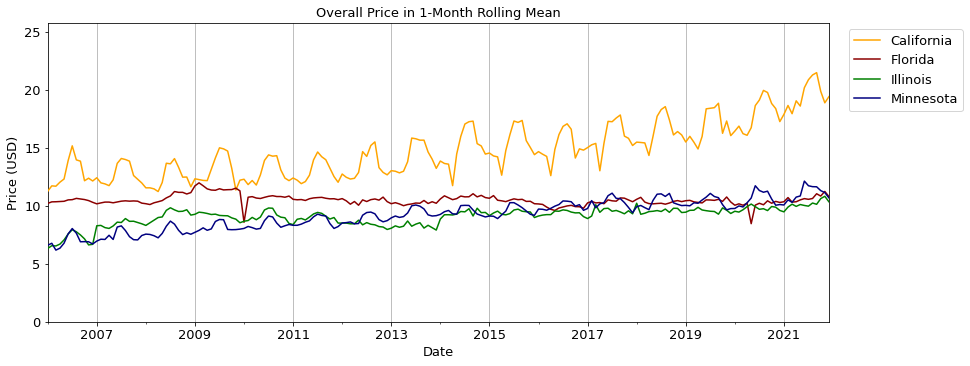

In [289]:
merged_line_byMonth(df_states_ALL, df_ALL_Price, 'Price', '1M', 'Overall')

### Merged Box graph

In [256]:
def merged_box(df_states, df_stats, variable, sector):
    df_merged = merge_data_by_column(df_states, variable)
    ax = df_merged.boxplot(figsize=(12,6), fontsize=fontsize)
    ax.set_ylim(0, df_stats["Max"].max()*1.2)
    ax.set_ylabel("%s Electricity %s (USD)" % (sector, variable), fontsize=fontsize);

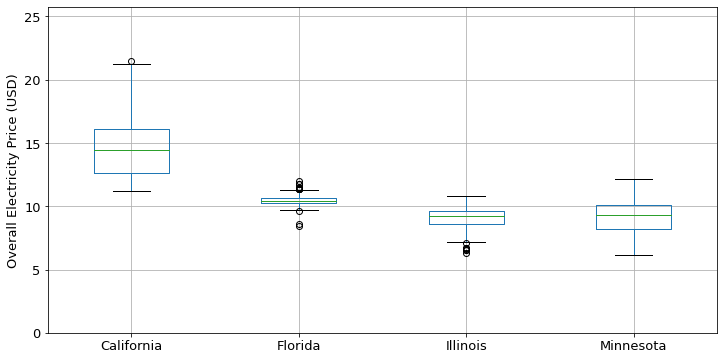

In [257]:
merged_box(df_states_ALL, df_ALL_Price, 'Price', 'Overall')

### Heatmap

In [281]:
def plot_heatmap(title, df_in, figsize=(5.5, 5)):
    df_corr = df_in.corr()
    # create a color palettte
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # display the heatmap
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df_corr, square=True, cbar=False,
                annot=True, cmap=cmap, linewidths=0.5, vmin=-1)
    ax.set_title("%s Correlations" % title)

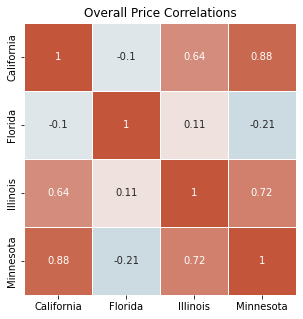

In [450]:
plot_heatmap("Overall Price", df_merged_ALL_Price)

## Analysis

### Overall Price Analysis

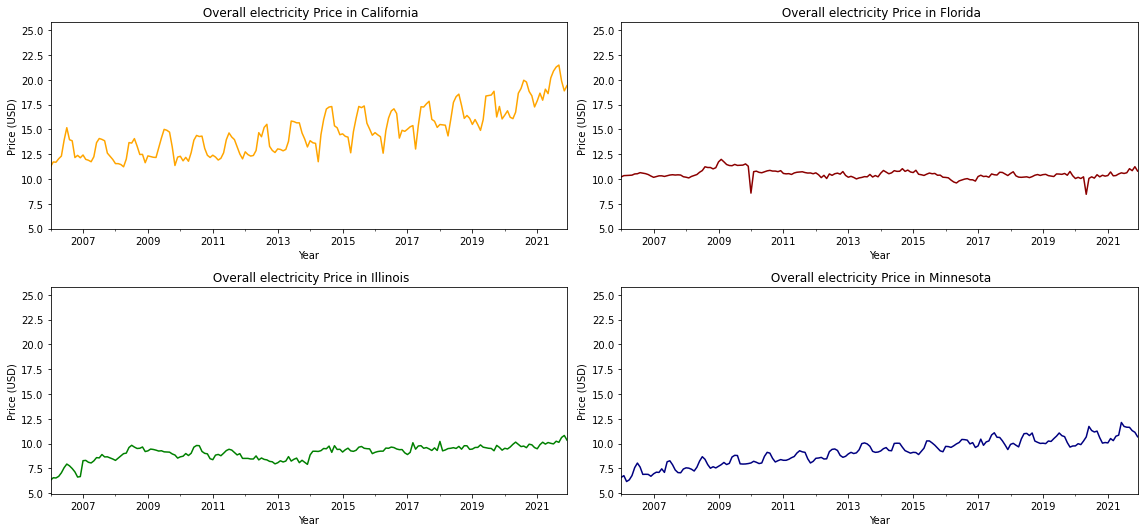

In [258]:
line(df_states_ALL, df_ALL_Price, 'Price', 'Overall')

We can tell from the graph below, the fluctuation in California is the most significant. 

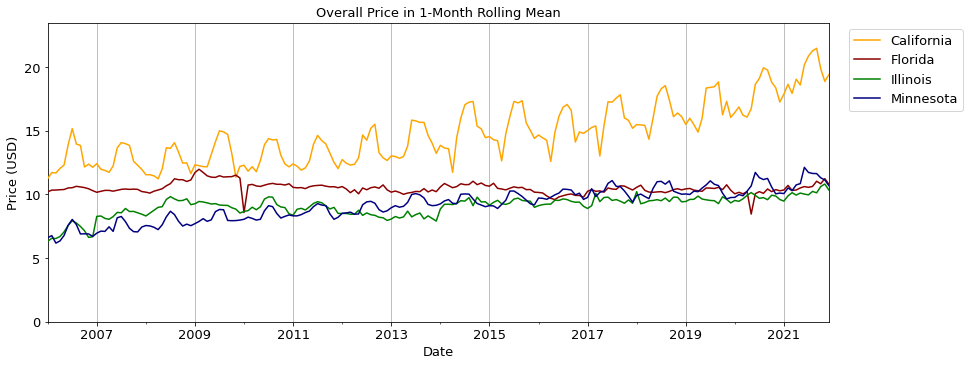

In [262]:
merged_line_byMonth(df_states_ALL, df_ALL_Price, 'Price', '1M', 'Overall')

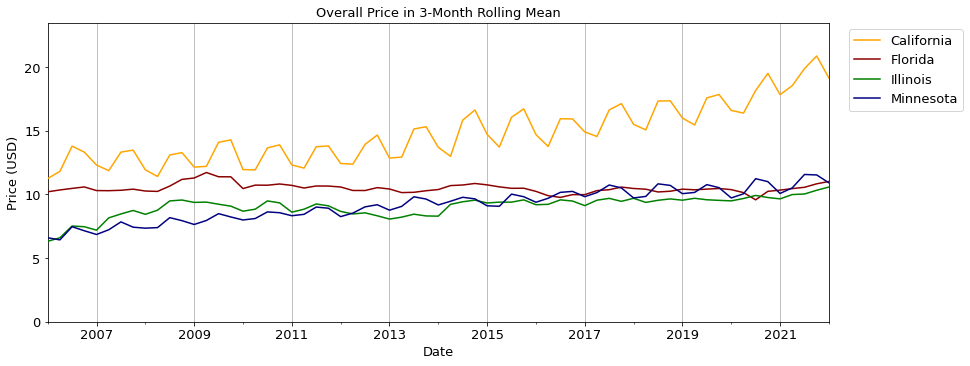

In [263]:
merged_line_byMonth(df_states_ALL, df_ALL_Price, 'Price', '3M', 'Overall')

Merging time period to 6 month as a unit makes it more clearly that the trend of each states. Among these 4, California has almost doubled the electricity price over this 16 years, Illinois and Minnesota has slight gone up, but still almost twice the price compared to the beginning, and Florida has the most stable price over the time.

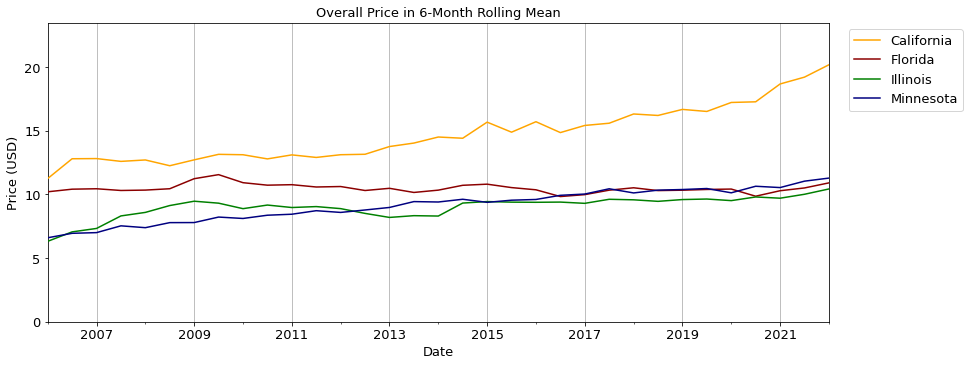

In [264]:
merged_line_byMonth(df_states_ALL, df_ALL_Price, 'Price', '6M', 'Overall')

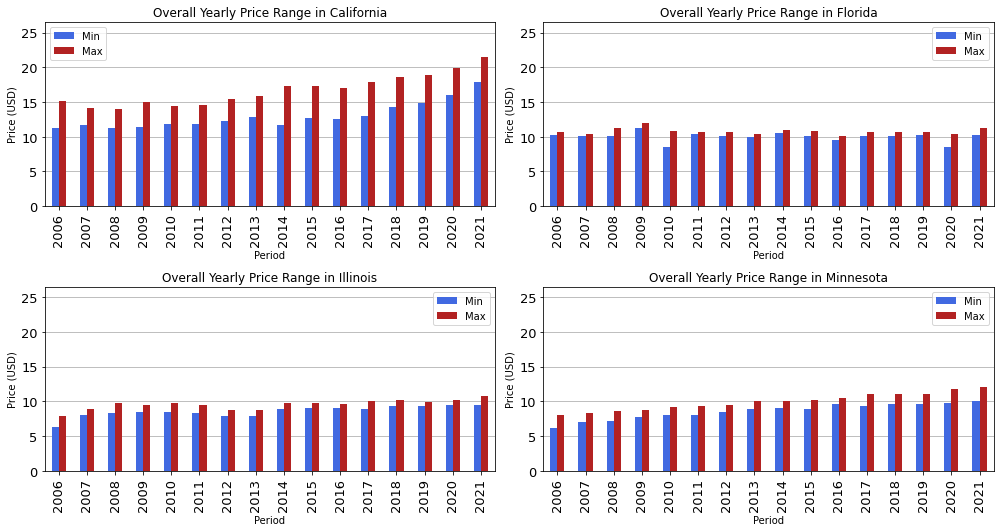

In [265]:
yearly_range_bar(df_states_ALL, df_ALL_Price, "Price", 'Overall')

With box plot, we have a more clearly view that who has the most or less volatile price.

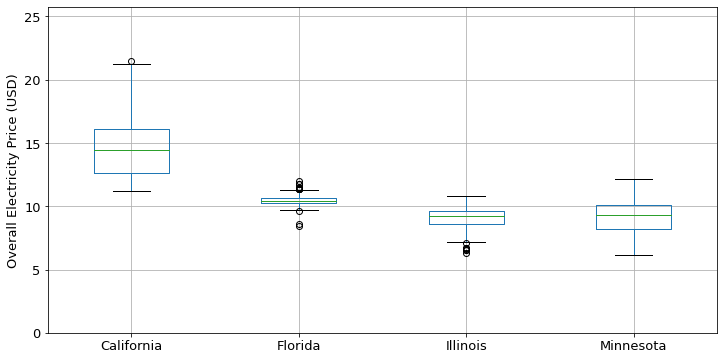

In [266]:
merged_box(df_states_ALL, df_ALL_Price, "Price", 'Overall')

With the help of heatmap, we can tell that California and Minnesota has the most similar pattern, following is Minnesota and Illinois then is California and Illinois. Since the electricity price in Florida is basically the same, so it is most irrelevant to other three.

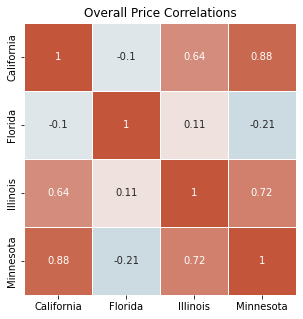

In [456]:
plot_heatmap("Overall Price", df_merged_ALL_Price)

### Industrial Price Analysis

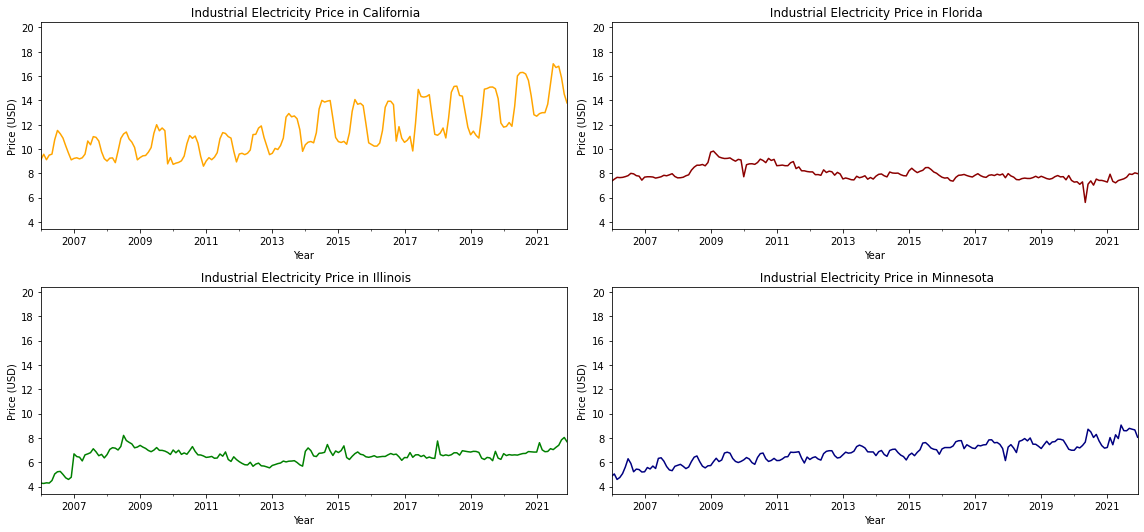

In [294]:
line(df_states_IND, df_IND_Price, 'Price', 'Industrial')

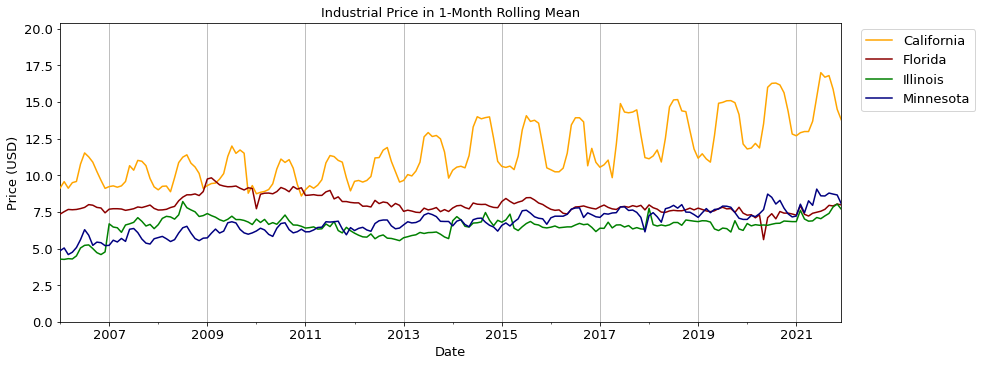

In [295]:
merged_line_byMonth(df_states_IND, df_IND_Price, 'Price', '1M', 'Industrial')

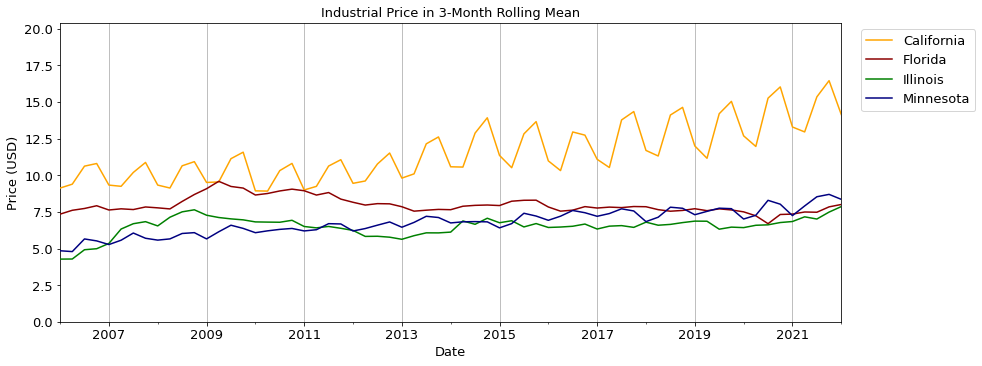

In [296]:
merged_line_byMonth(df_states_IND, df_IND_Price, 'Price', '3M', 'Industrial')

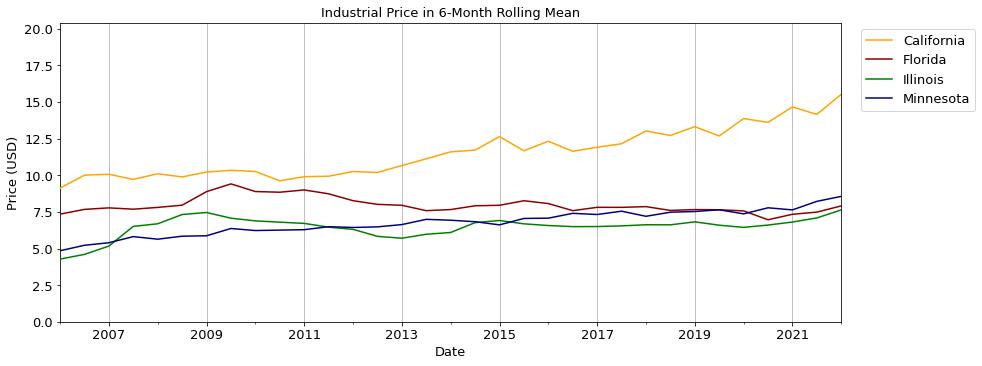

In [297]:
merged_line_byMonth(df_states_IND, df_IND_Price, 'Price', '6M', 'Industrial')

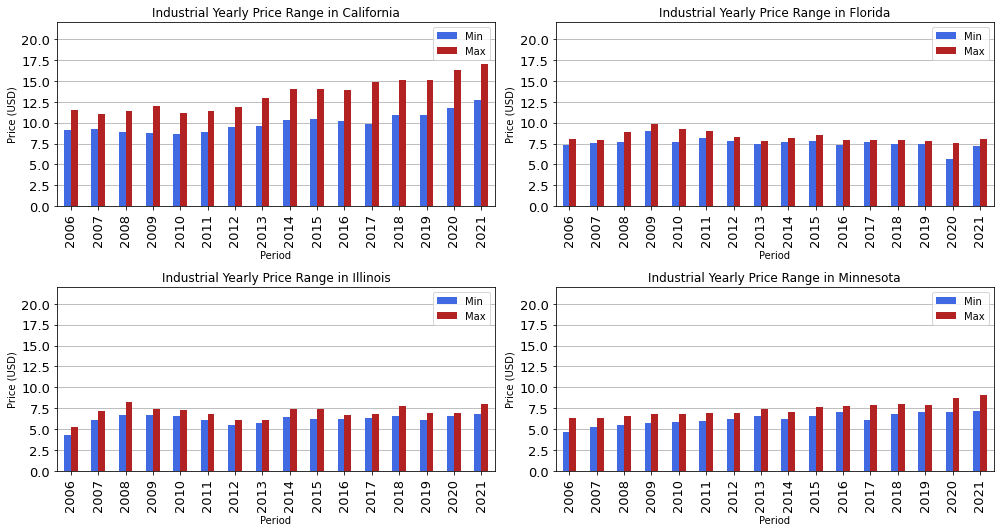

In [298]:
yearly_range_bar(df_states_IND, df_IND_Price, "Price", 'Industrial')

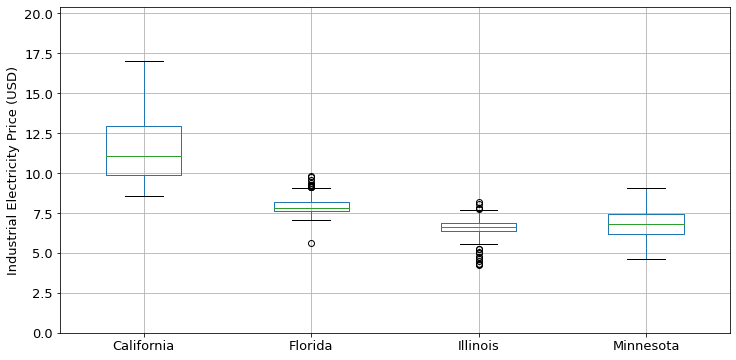

In [299]:
merged_box(df_states_IND, df_IND_Price, "Price", 'Industrial')

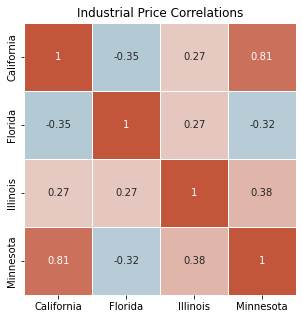

In [457]:
plot_heatmap("Industrial Price", df_merged_IND_Price)

### Residential Price Analysis

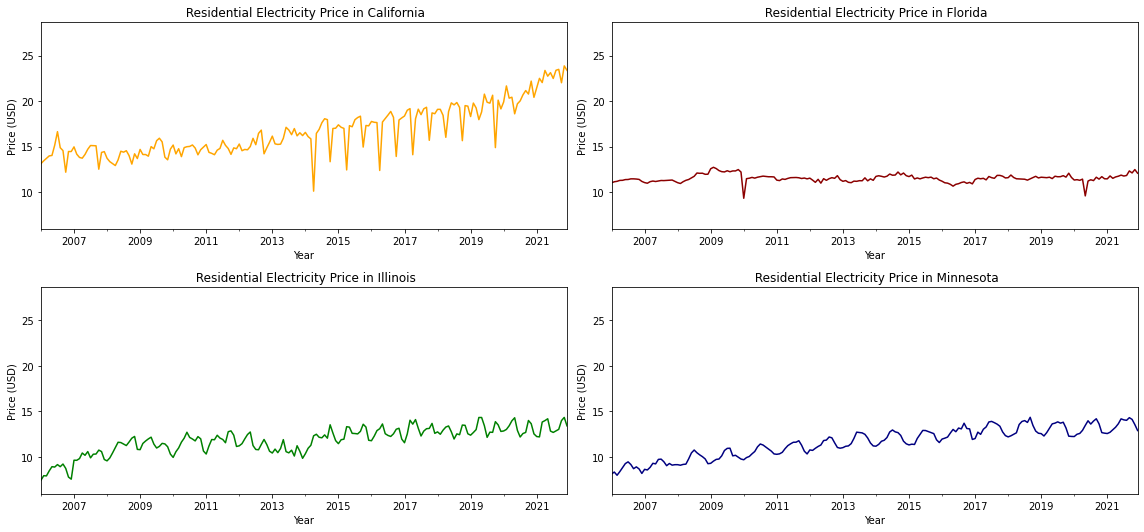

In [300]:
line(df_states_RES, df_RES_Price, 'Price', 'Residential')

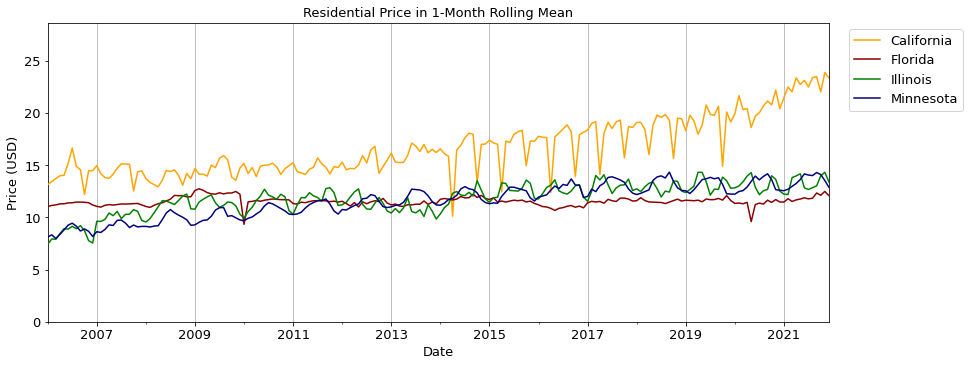

In [301]:
merged_line_byMonth(df_states_RES, df_RES_Price, 'Price', '1M', 'Residential')

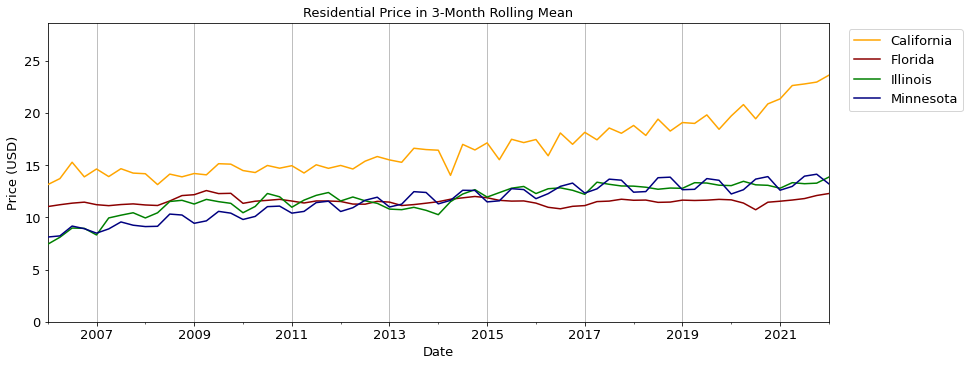

In [302]:
merged_line_byMonth(df_states_RES, df_RES_Price, 'Price', '3M', 'Residential')

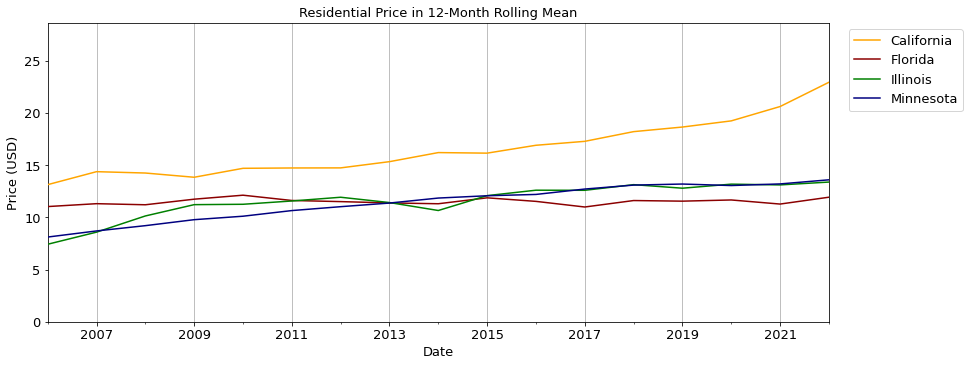

In [303]:
merged_line_byMonth(df_states_RES, df_RES_Price, 'Price', '12M', 'Residential')

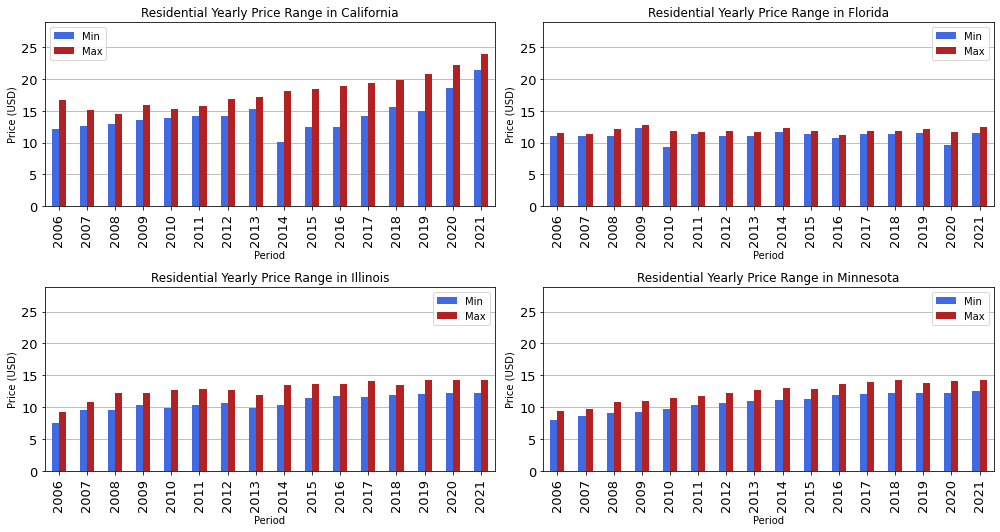

In [304]:
yearly_range_bar(df_states_RES, df_RES_Price, "Price", 'Residential')

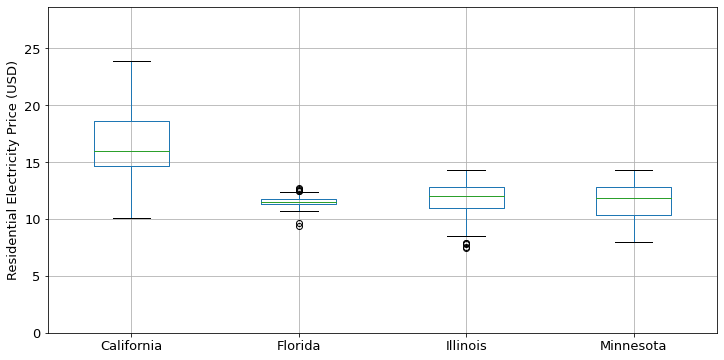

In [305]:
merged_box(df_states_RES, df_RES_Price, "Price", 'Residential')

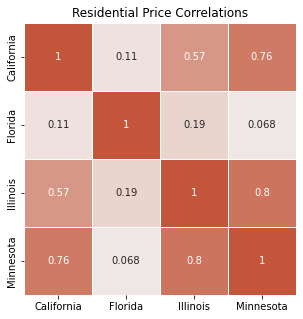

In [458]:
plot_heatmap("Residential Price", df_merged_RES_Price)

### Commercial Price Analysis

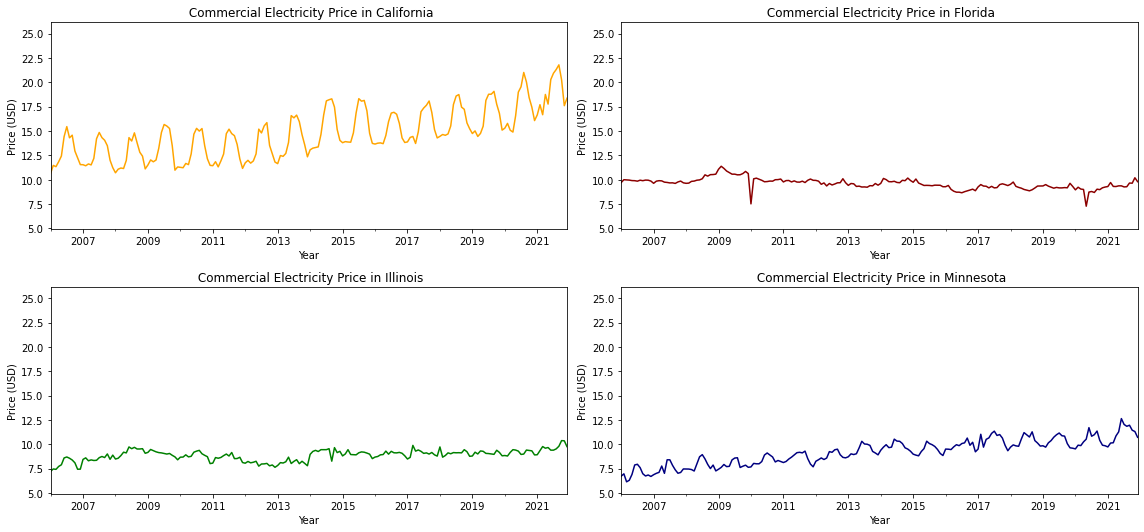

In [306]:
line(df_states_COM, df_COM_Price, 'Price', 'Commercial')

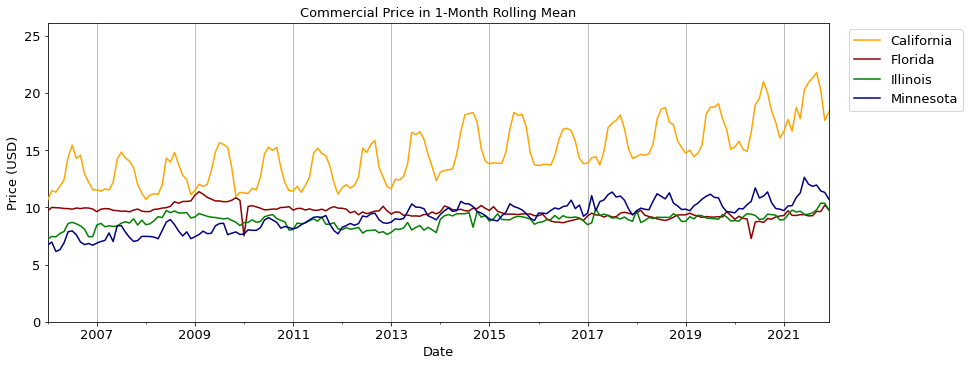

In [307]:
merged_line_byMonth(df_states_COM, df_COM_Price, 'Price', '1M', 'Commercial')

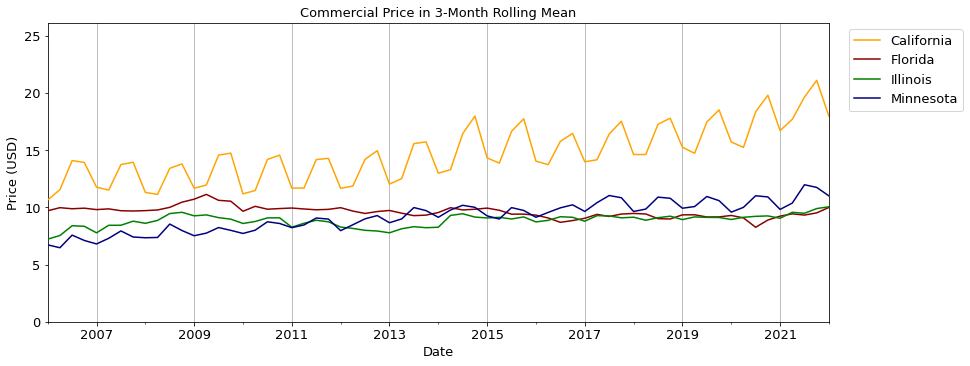

In [308]:
merged_line_byMonth(df_states_COM, df_COM_Price, 'Price', '3M', 'Commercial')

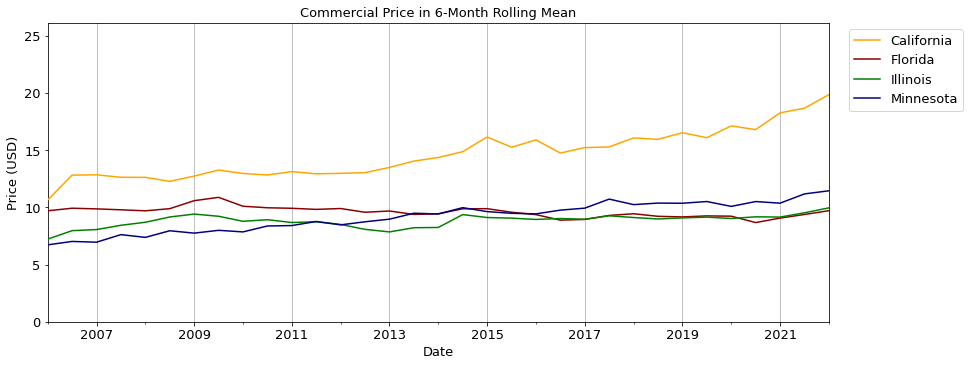

In [309]:
merged_line_byMonth(df_states_COM, df_COM_Price, 'Price', '6M', 'Commercial')

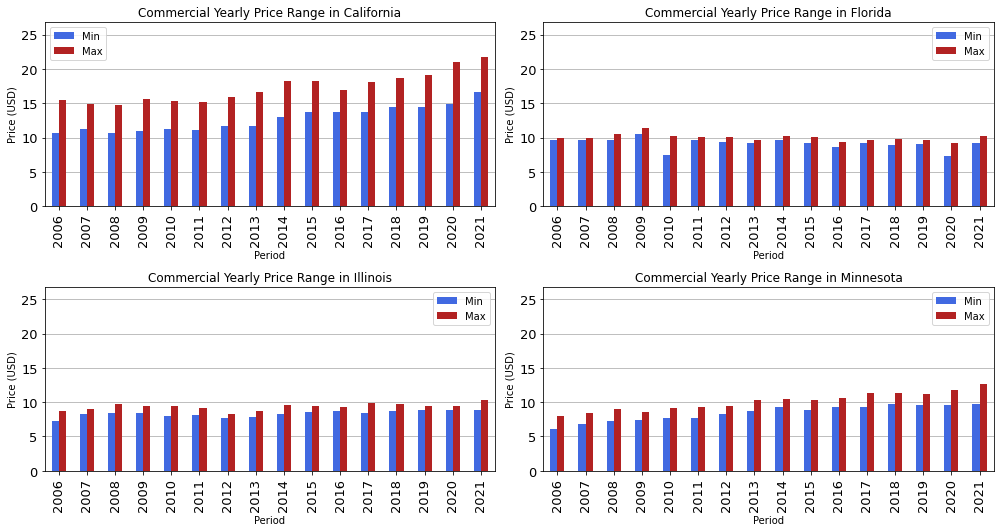

In [310]:
yearly_range_bar(df_states_COM, df_COM_Price, "Price", 'Commercial')

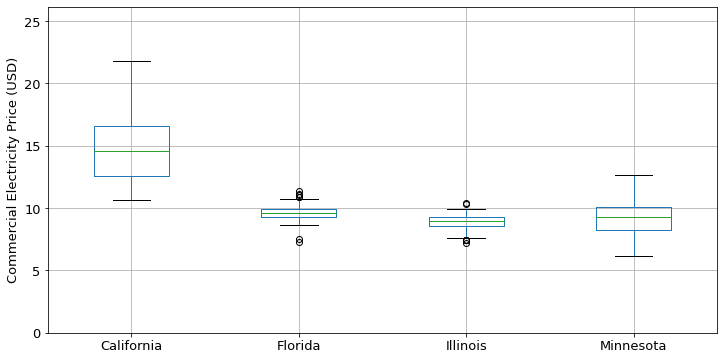

In [311]:
merged_box(df_states_COM, df_COM_Price, "Price", 'Commercial')

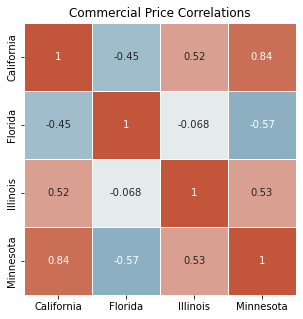

In [459]:
plot_heatmap("Commercial Price", df_merged_COM_Price)

### Price Analysis

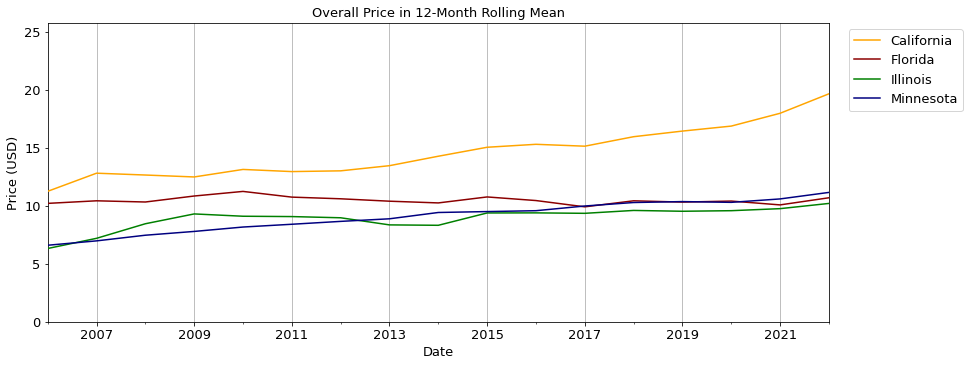

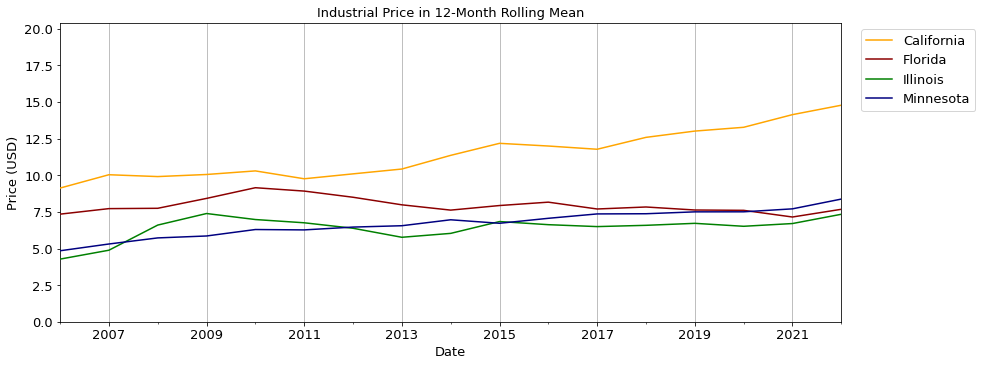

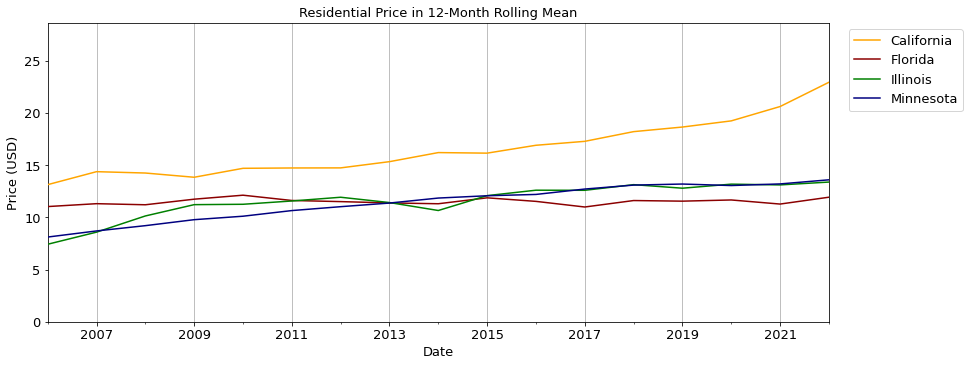

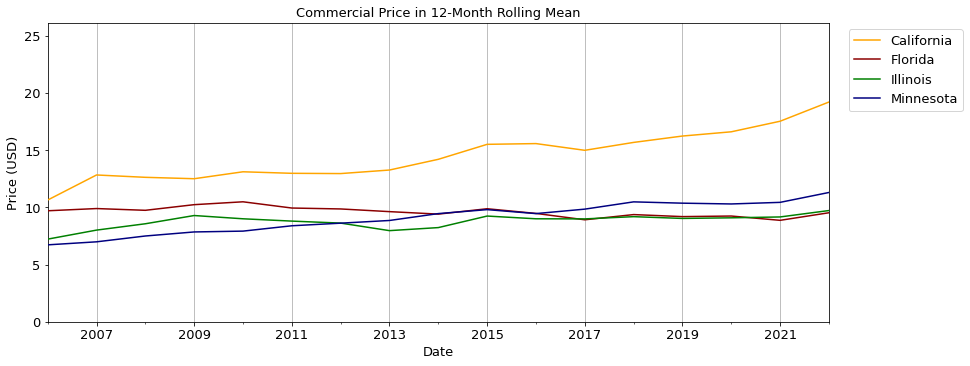

In [520]:
merged_line_byMonth(df_states_ALL, df_ALL_Price, 'Price', '12M', 'Overall')
merged_line_byMonth(df_states_IND, df_IND_Price, 'Price', '12M', 'Industrial')
merged_line_byMonth(df_states_RES, df_RES_Price, 'Price', '12M', 'Residential')
merged_line_byMonth(df_states_COM, df_COM_Price, 'Price', '12M', 'Commercial')

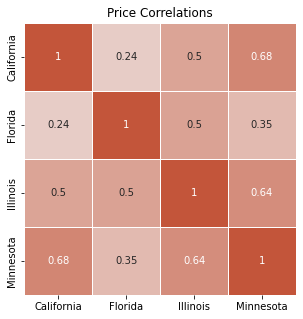

In [460]:
plot_heatmap("Price", df_merged_Price)

### Overall Sales Analysis
All we know now is that there's fluctuation in sales during this preriod and seems like it has a pattern.

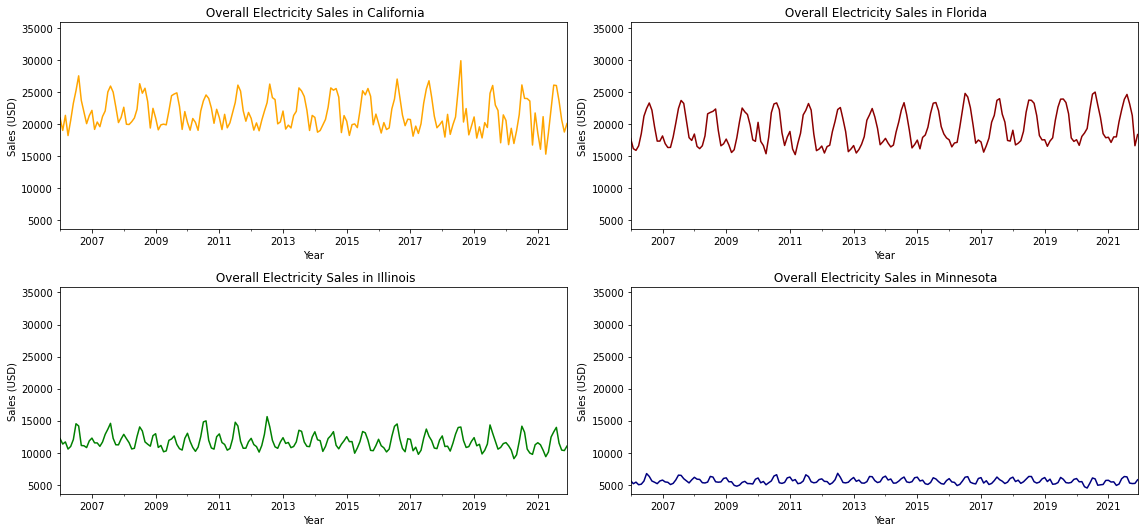

In [329]:
line(df_states_ALL, df_ALL_Sales, 'Sales', 'Overall')

With this, we can tell that the sales amount for these 4 states are related, in some specific months of a year, the demand of electricity is high and some are low.

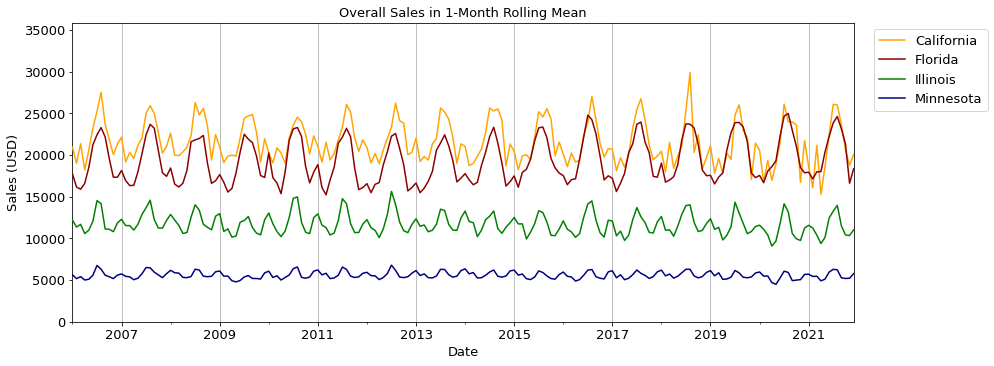

In [330]:
merged_line_byMonth(df_states_ALL, df_ALL_Sales, 'Sales', '1M', 'Overall')

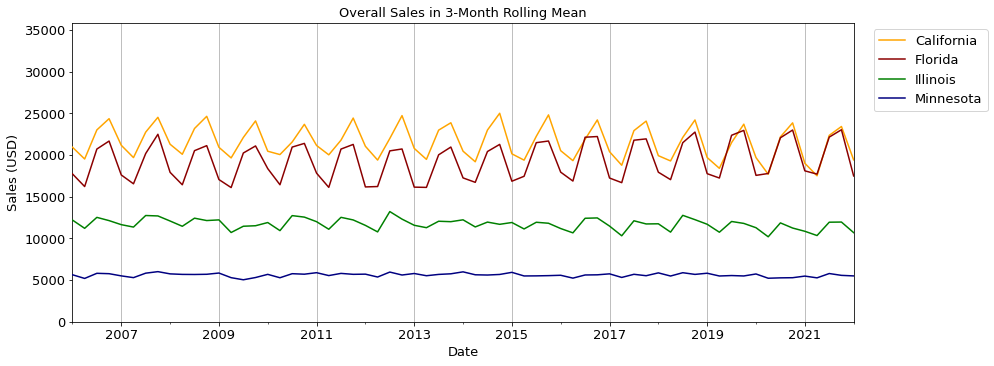

In [331]:
merged_line_byMonth(df_states_ALL, df_ALL_Sales, 'Sales', '3M', 'Overall')

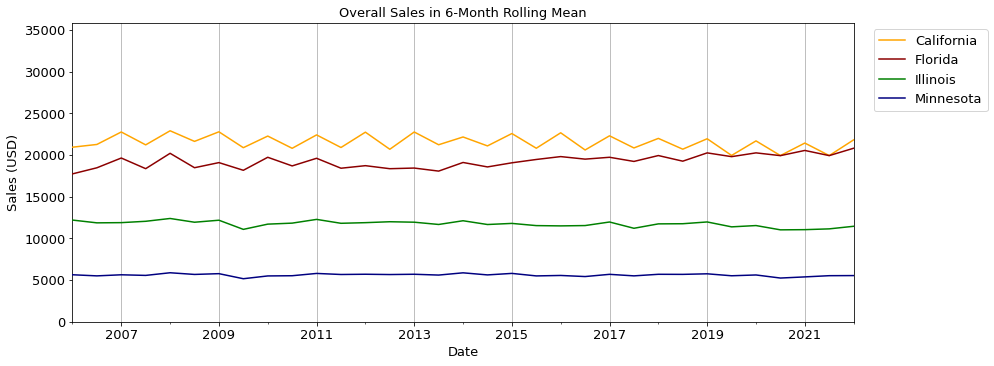

In [332]:
merged_line_byMonth(df_states_ALL, df_ALL_Sales, 'Sales', '6M', 'Overall')

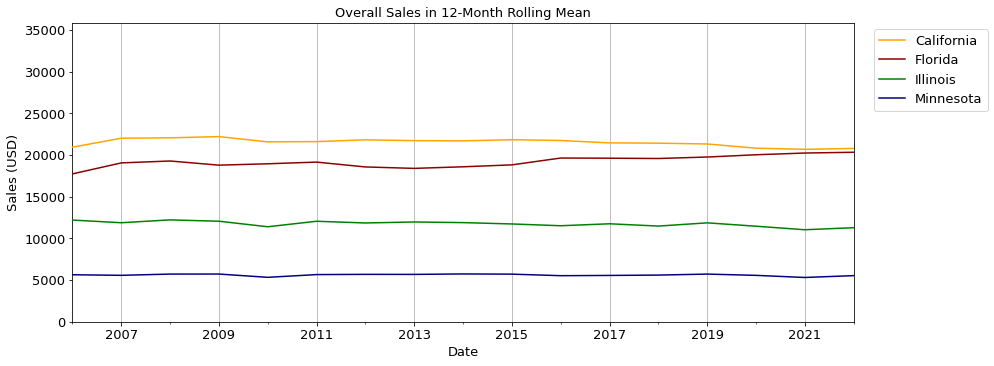

In [333]:
merged_line_byMonth(df_states_ALL, df_ALL_Sales, 'Sales', '12M', 'Overall')

With the bar chart below, we can see that the gap of max and min sales in California, Florida and Illinois are big, compared to Minnesota.

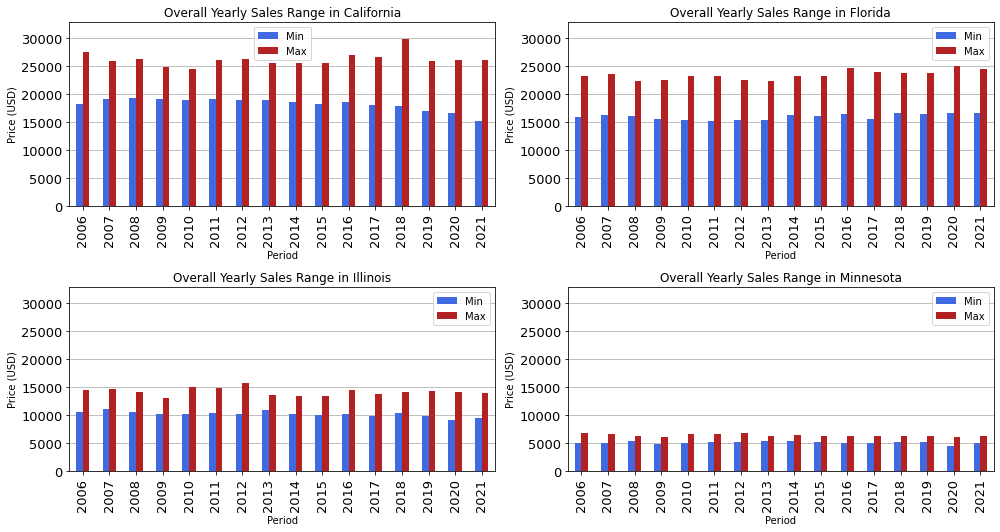

In [339]:
yearly_range_bar(df_states_ALL, df_ALL_Sales, "Sales", 'Overall')

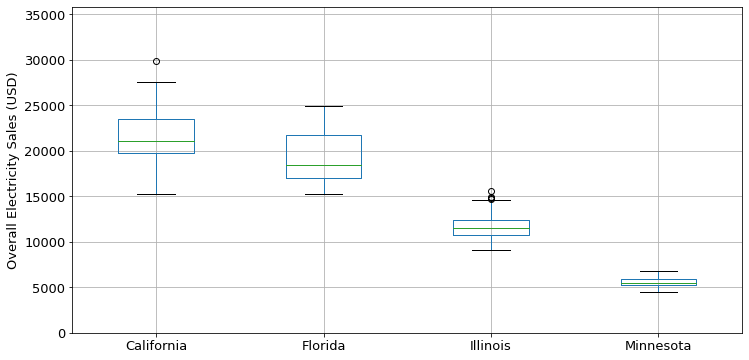

In [340]:
merged_box(df_states_ALL, df_ALL_Sales, "Sales", 'Overall')

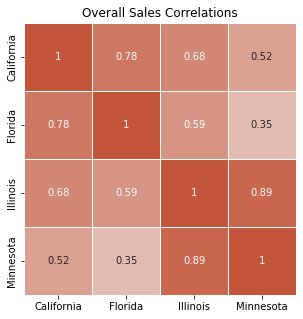

In [461]:
plot_heatmap("Overall Sales", df_merged_ALL_Sales)

### Industrial Sales Analysis

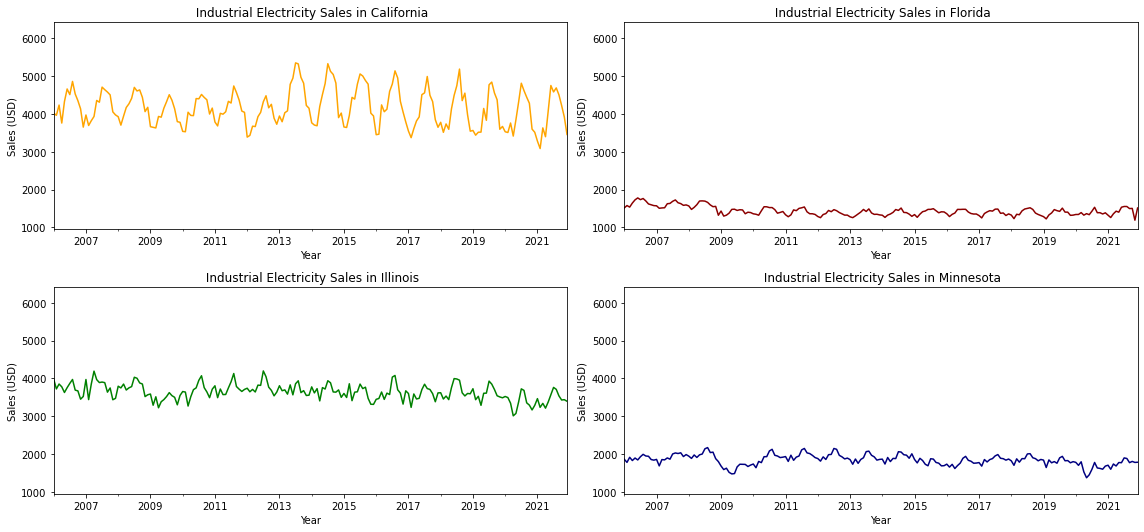

In [424]:
line(df_states_IND, df_IND_Sales, 'Sales', 'Industrial')

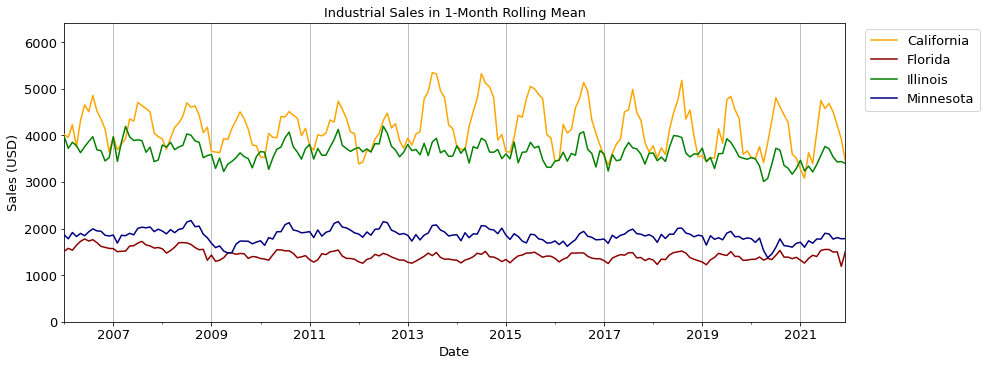

In [425]:
merged_line_byMonth(df_states_IND, df_IND_Sales, 'Sales', '1M', 'Industrial')

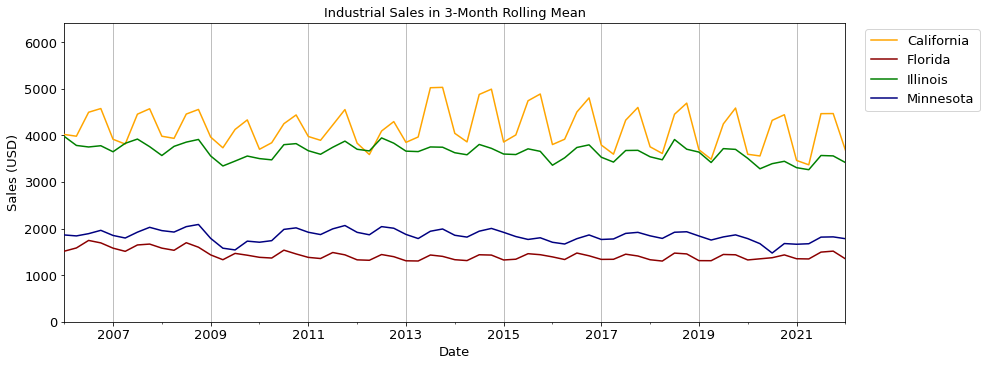

In [426]:
merged_line_byMonth(df_states_IND, df_IND_Sales, 'Sales', '3M', 'Industrial')

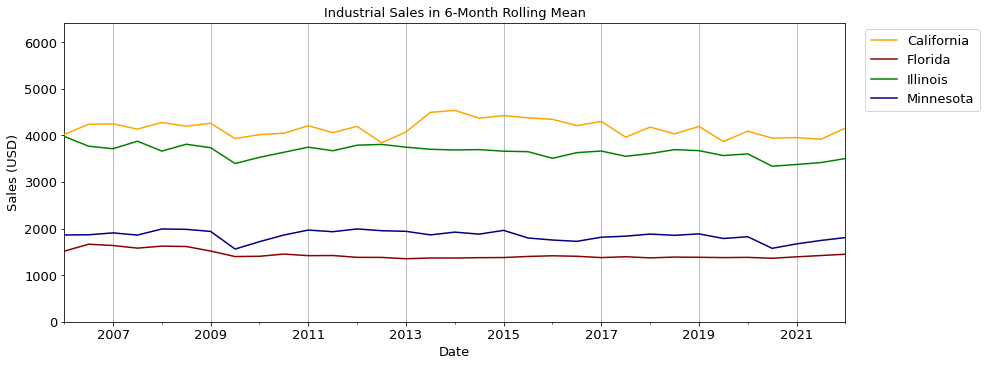

In [427]:
merged_line_byMonth(df_states_IND, df_IND_Sales, 'Sales', '6M', 'Industrial')

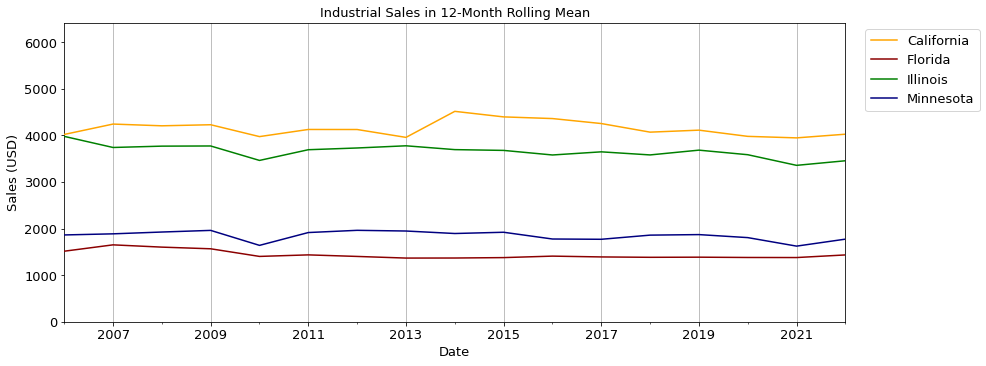

In [428]:
merged_line_byMonth(df_states_IND, df_IND_Sales, 'Sales', '12M', 'Industrial')

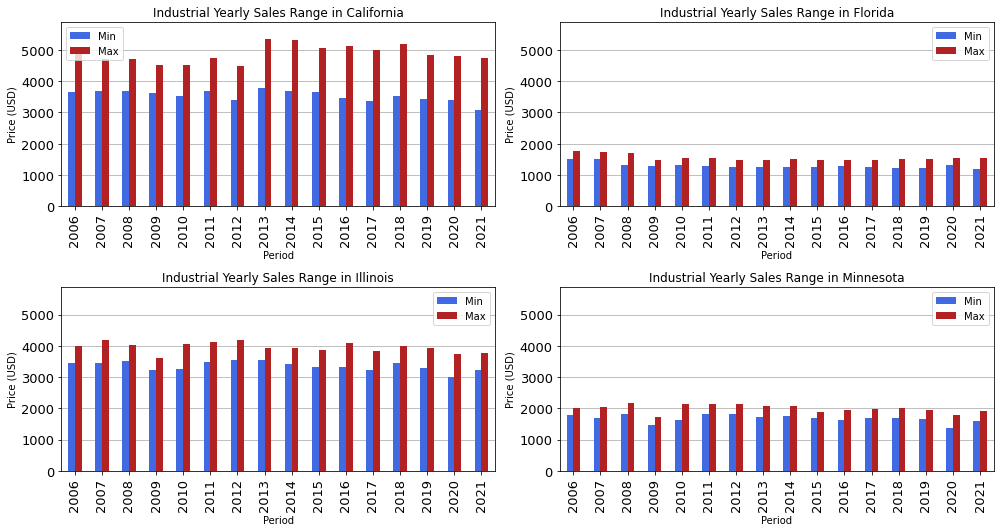

In [429]:
yearly_range_bar(df_states_IND, df_IND_Sales, "Sales", 'Industrial')

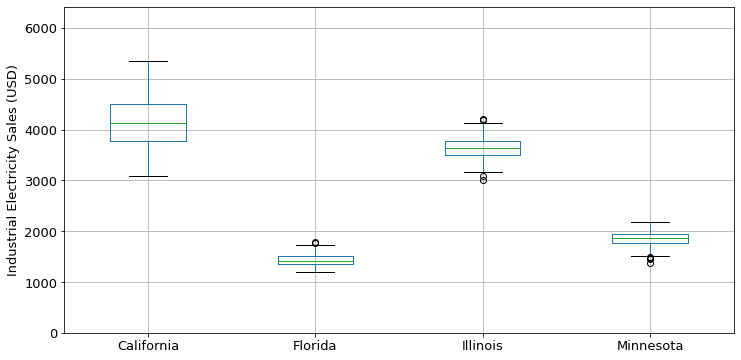

In [430]:
merged_box(df_states_IND, df_IND_Sales, "Sales", 'Industrial')

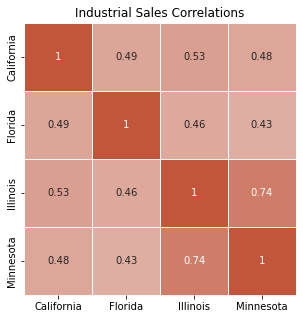

In [462]:
plot_heatmap("Industrial Sales", df_merged_IND_Sales)

### Residential Sales Analysis

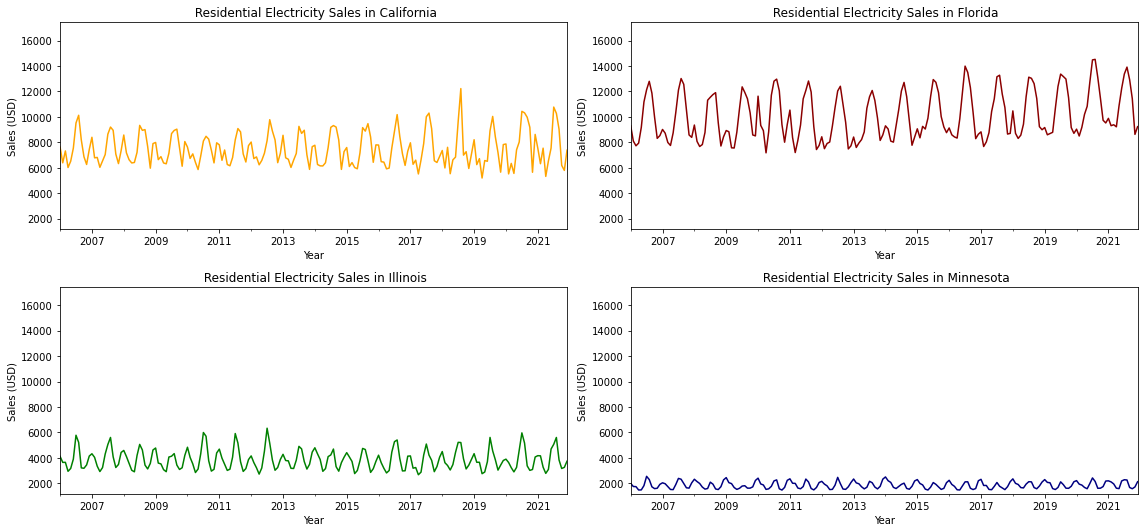

In [431]:
line(df_states_RES, df_RES_Sales, 'Sales', 'Residential')

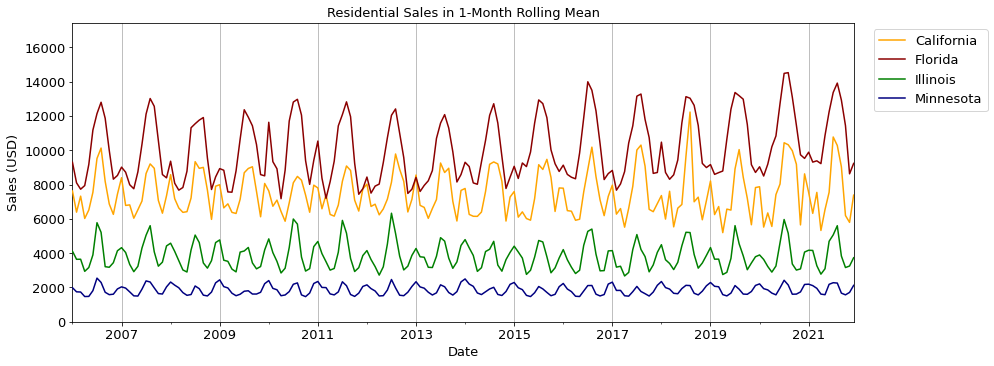

In [432]:
merged_line_byMonth(df_states_RES, df_RES_Sales, 'Sales', '1M', 'Residential')

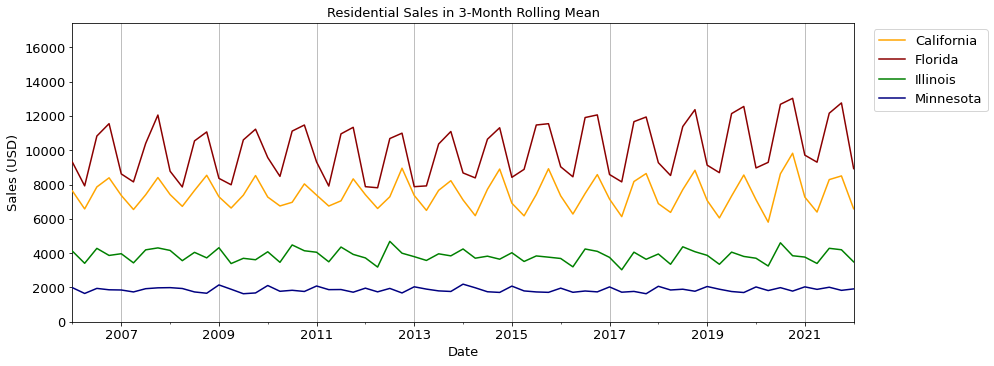

In [433]:
merged_line_byMonth(df_states_RES, df_RES_Sales, 'Sales', '3M', 'Residential')

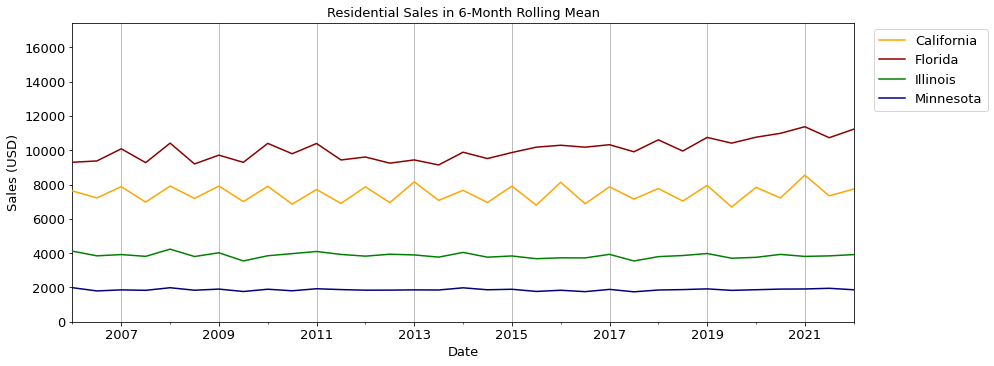

In [434]:
merged_line_byMonth(df_states_RES, df_RES_Sales, 'Sales', '6M', 'Residential')

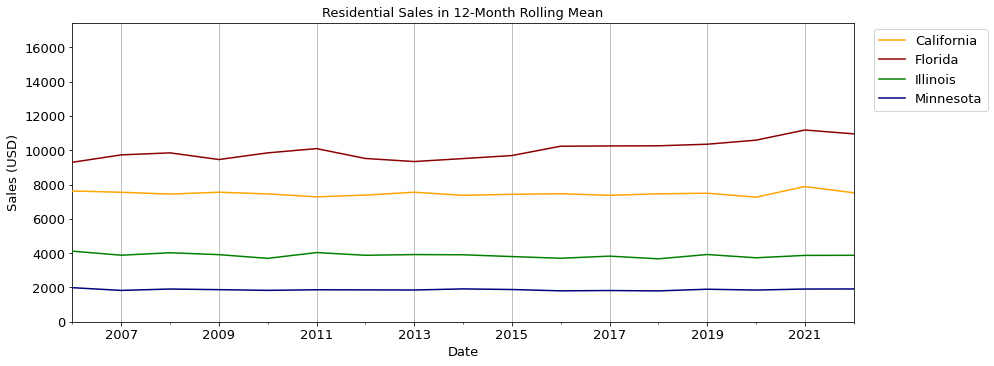

In [435]:
merged_line_byMonth(df_states_RES, df_RES_Sales, 'Sales', '12M', 'Residential')

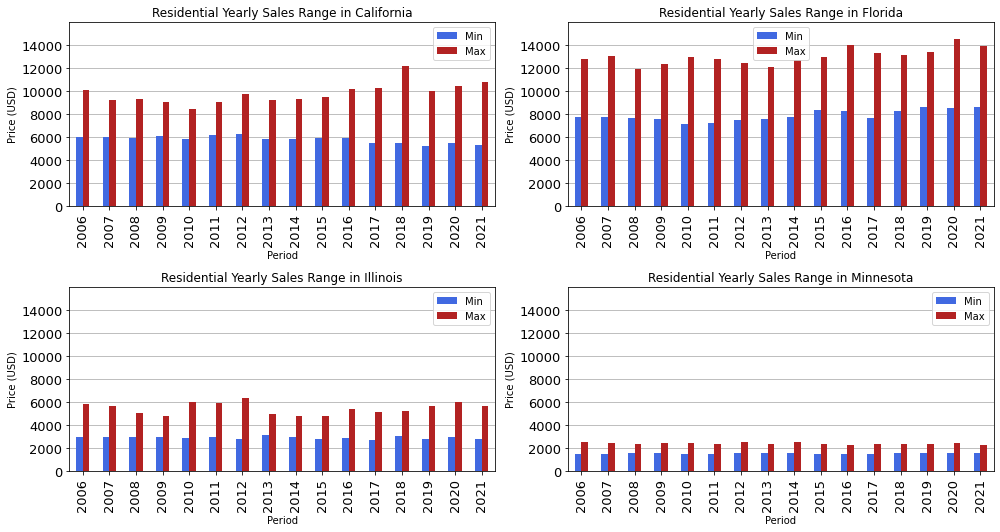

In [436]:
yearly_range_bar(df_states_RES, df_RES_Sales, "Sales", 'Residential')

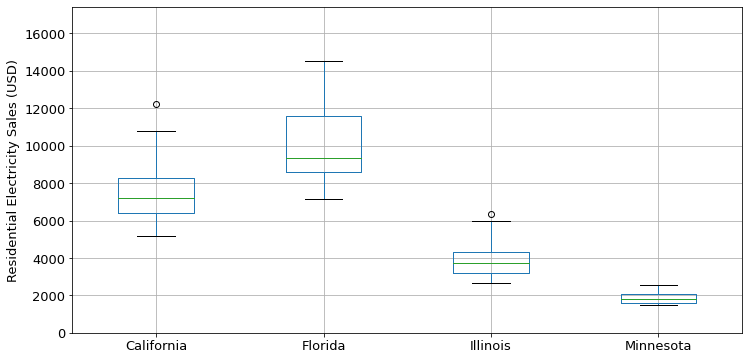

In [437]:
merged_box(df_states_RES, df_RES_Sales, "Sales", 'Residential')

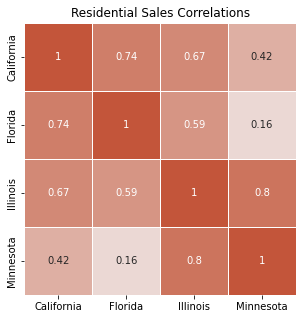

In [463]:
plot_heatmap("Residential Sales", df_merged_RES_Sales)

### Commercial Sales Analysis

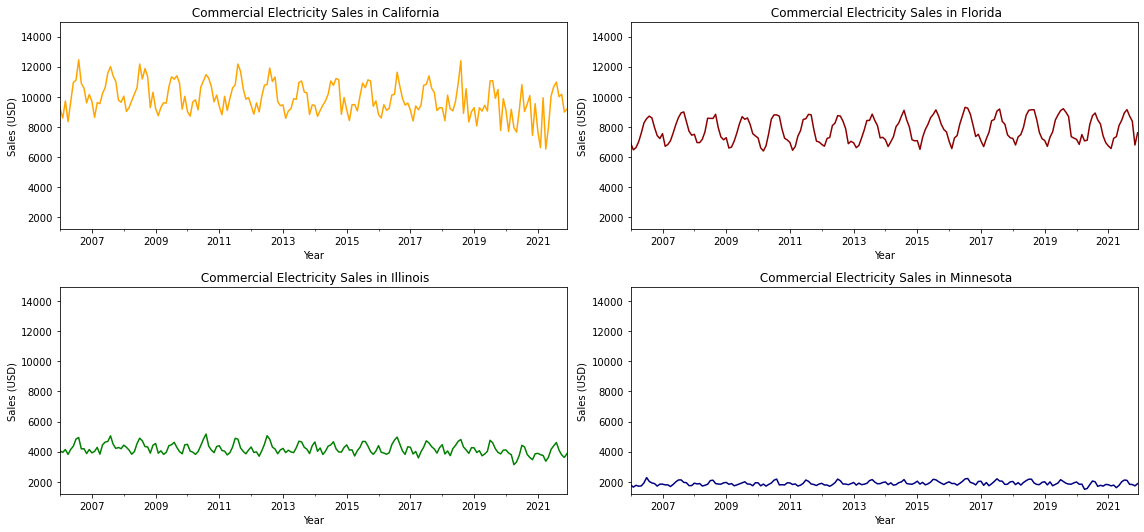

In [438]:
line(df_states_COM, df_COM_Sales, 'Sales', 'Commercial')

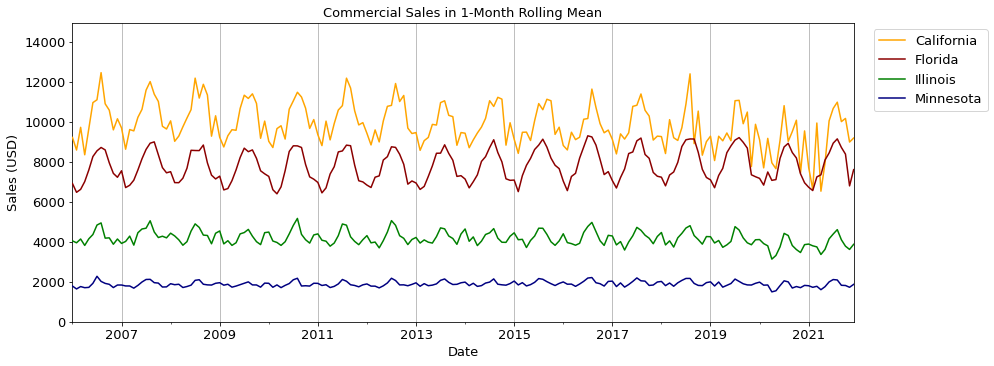

In [439]:
merged_line_byMonth(df_states_COM, df_COM_Sales, 'Sales', '1M', 'Commercial')

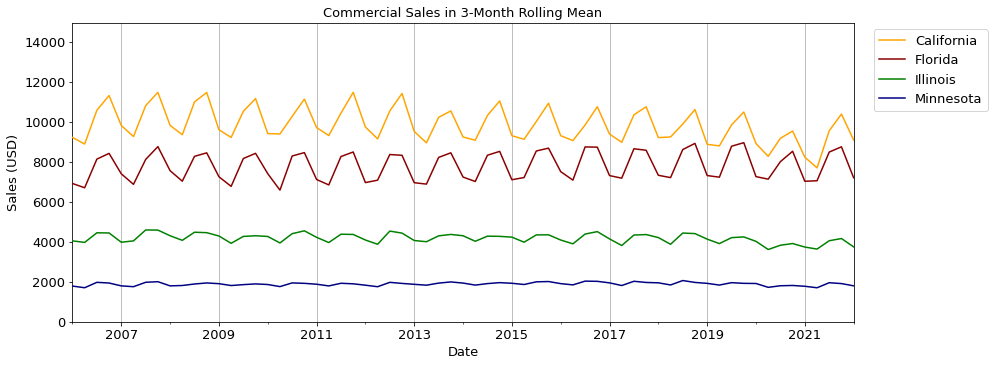

In [440]:
merged_line_byMonth(df_states_COM, df_COM_Sales, 'Sales', '3M', 'Commercial')

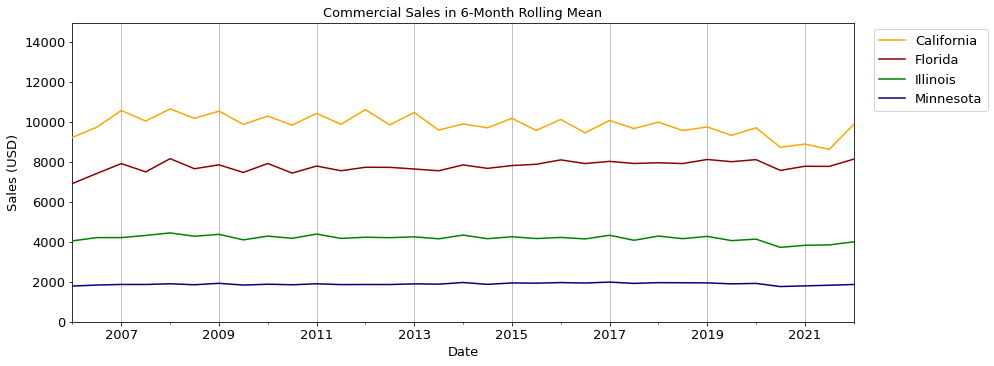

In [442]:
merged_line_byMonth(df_states_COM, df_COM_Sales, 'Sales', '6M', 'Commercial')

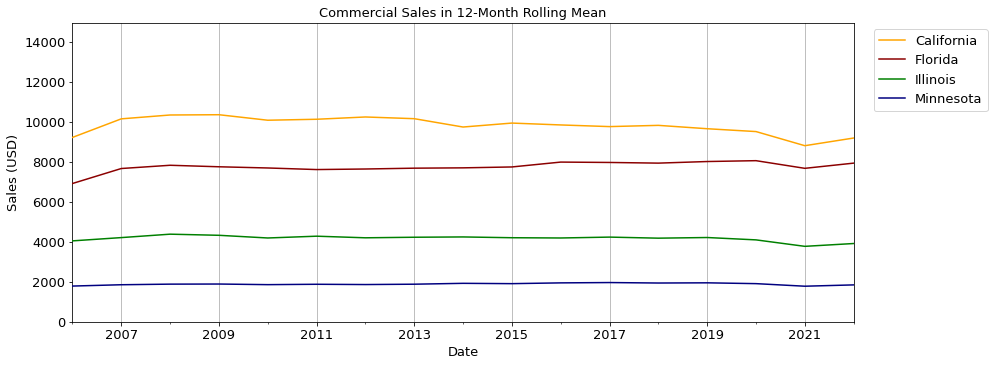

In [443]:
merged_line_byMonth(df_states_COM, df_COM_Sales, 'Sales', '12M', 'Commercial')

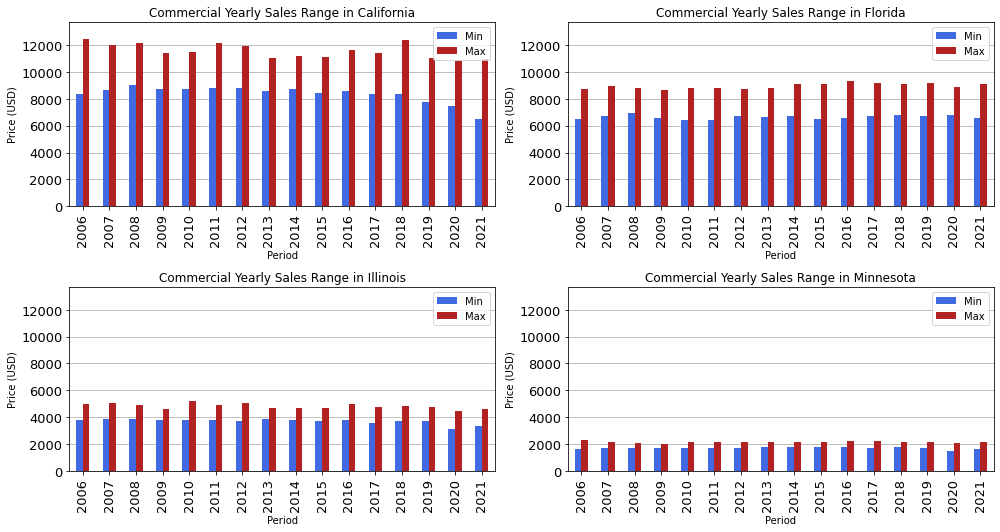

In [444]:
yearly_range_bar(df_states_COM, df_COM_Sales, "Sales", 'Commercial')

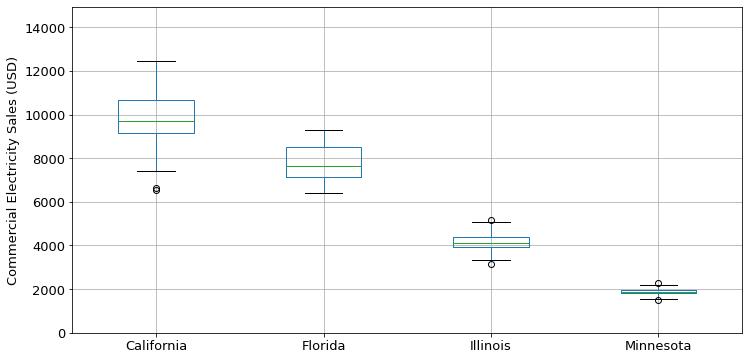

In [445]:
merged_box(df_states_COM, df_COM_Sales, "Sales", 'Commercial')

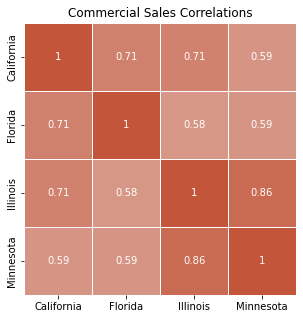

In [464]:
plot_heatmap("Commercial Sales", df_merged_COM_Sales)

### Sales Analysis

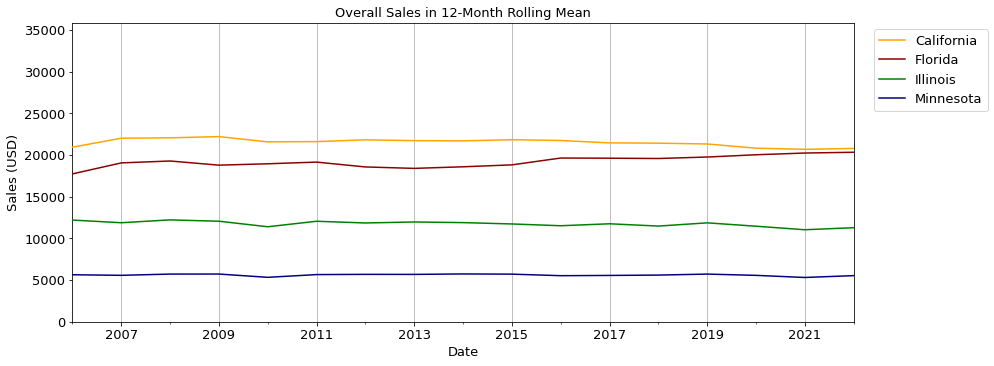

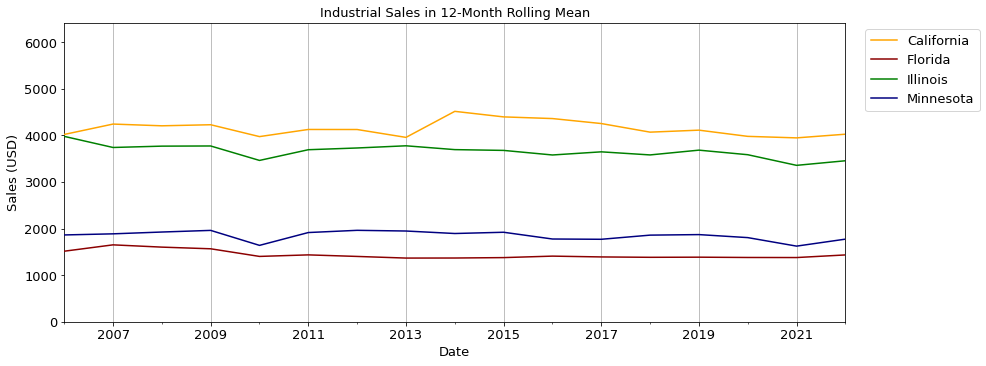

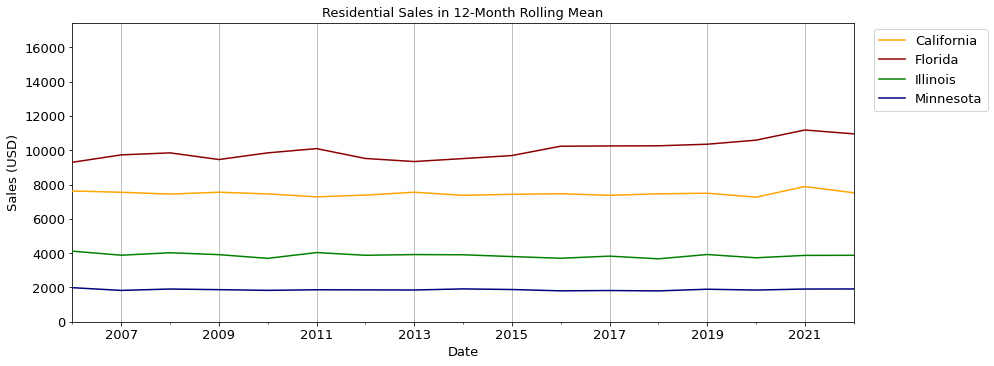

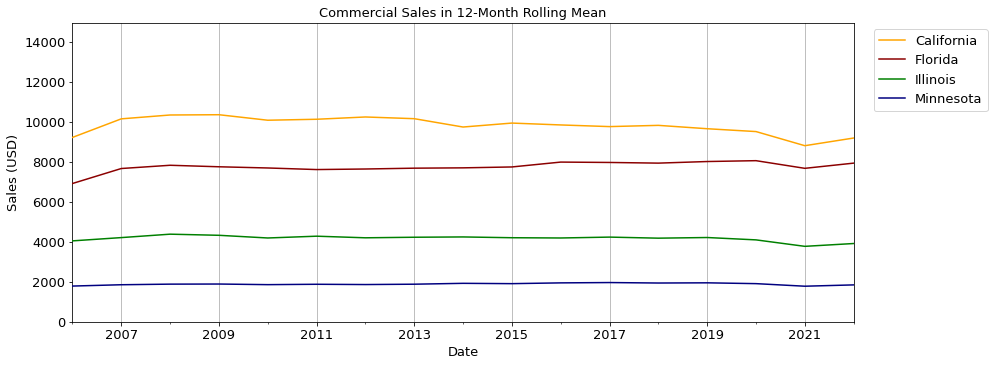

In [447]:
merged_line_byMonth(df_states_ALL, df_ALL_Sales, 'Sales', '12M', 'Overall')
merged_line_byMonth(df_states_IND, df_IND_Sales, 'Sales', '12M', 'Industrial')
merged_line_byMonth(df_states_RES, df_RES_Sales, 'Sales', '12M', 'Residential')
merged_line_byMonth(df_states_COM, df_COM_Sales, 'Sales', '12M', 'Commercial')

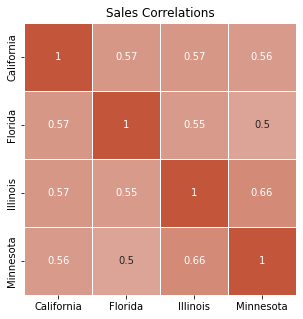

In [465]:
plot_heatmap("Sales", df_merged_Sales)

### Overall Revenue Analysis

After the sales, we take a look on revenue, we can tell that it fluctuates in a pattern too.

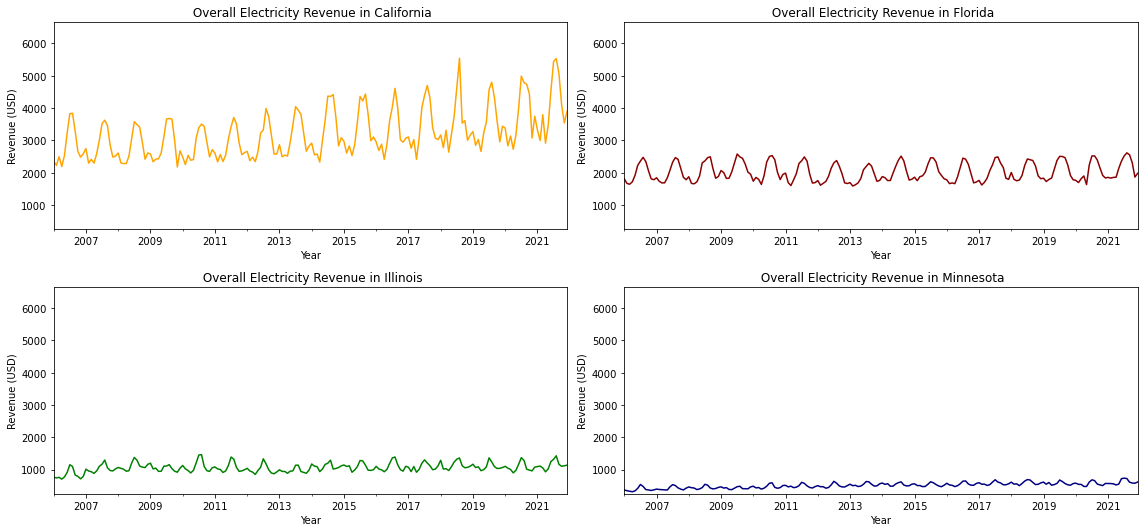

In [341]:
line(df_states_ALL, df_ALL_Rev, 'Revenue', 'Overall')

And the revenue seems going a little up in California.

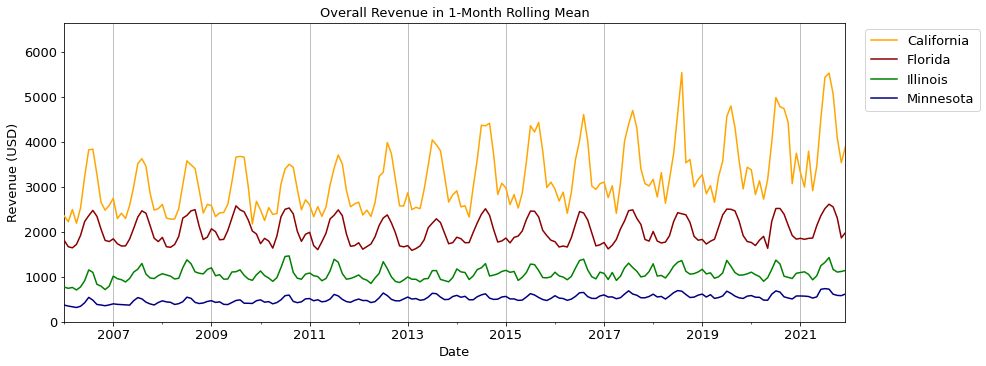

In [521]:
merged_line_byMonth(df_states_ALL, df_ALL_Rev, 'Revenue', '1M', 'Overall')

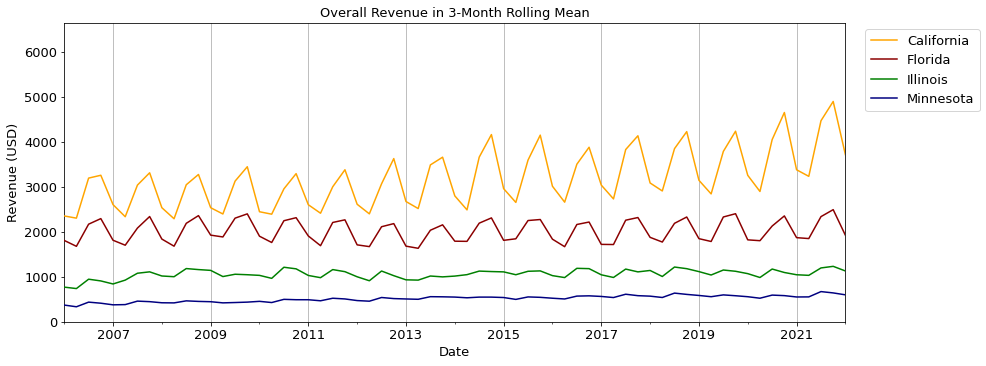

In [343]:
merged_line_byMonth(df_states_ALL, df_ALL_Rev, 'Revenue', '3M', 'Overall')

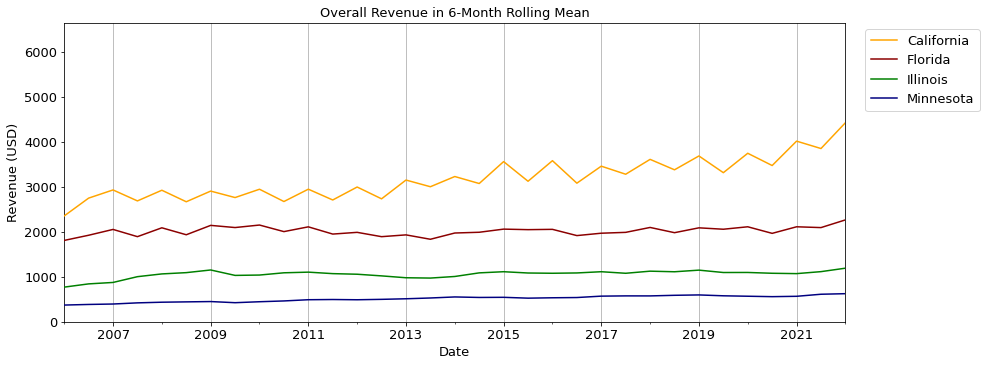

In [344]:
merged_line_byMonth(df_states_ALL, df_ALL_Rev, 'Revenue', '6M', 'Overall')

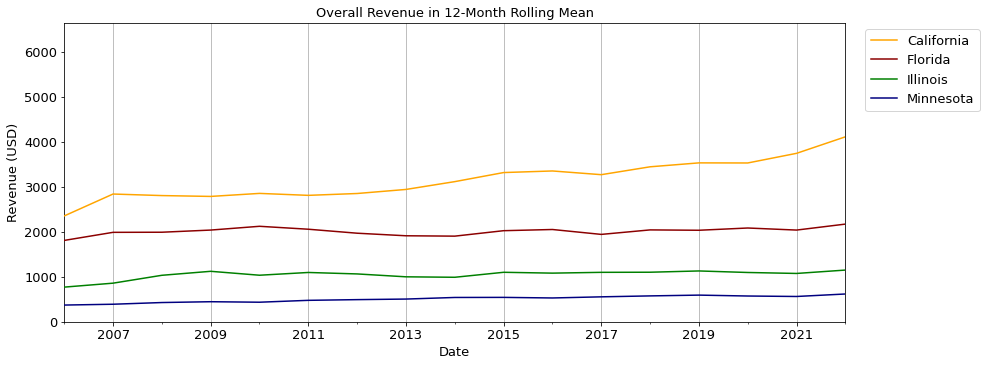

In [345]:
merged_line_byMonth(df_states_ALL, df_ALL_Rev, 'Revenue', '12M', 'Overall')

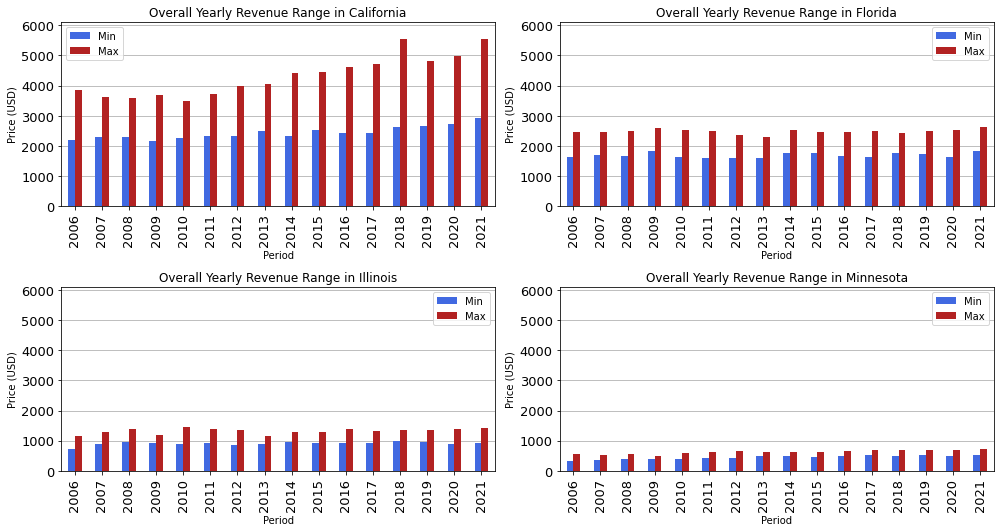

In [346]:
yearly_range_bar(df_states_ALL, df_ALL_Rev, "Revenue", 'Overall')

The fluctuation in California is the biggese from the box plot, second one is Florida, and then Illinois, and Minnesota is the most stable one.


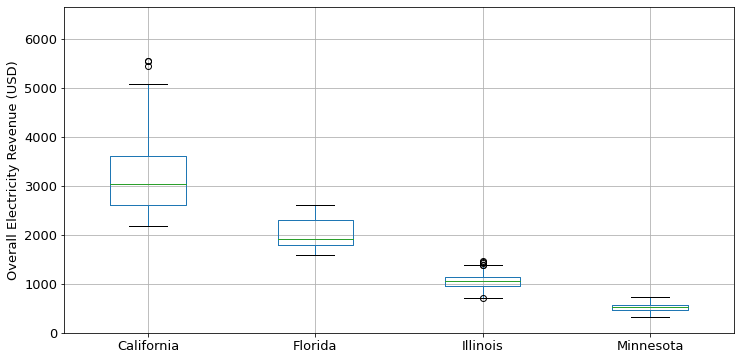

In [347]:
merged_box(df_states_ALL, df_ALL_Rev, "Revenue", 'Overall')

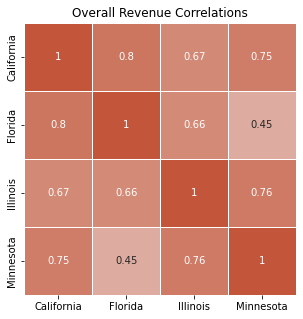

In [466]:
plot_heatmap("Overall Revenue", df_merged_ALL_Re)

### Revenue Analysis

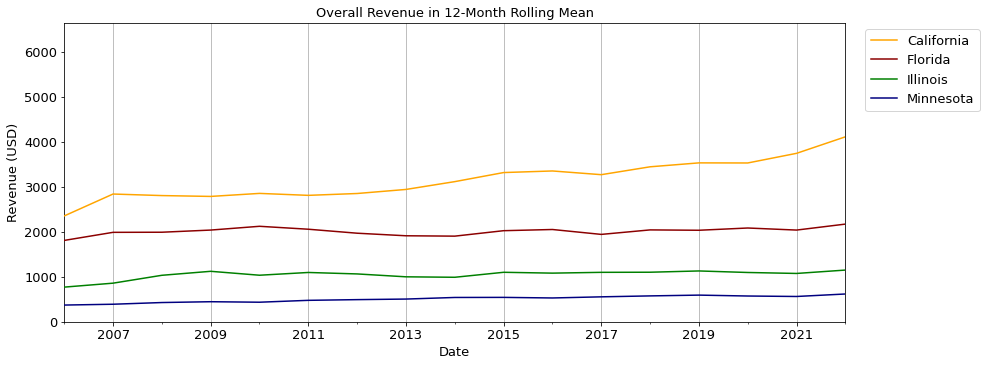

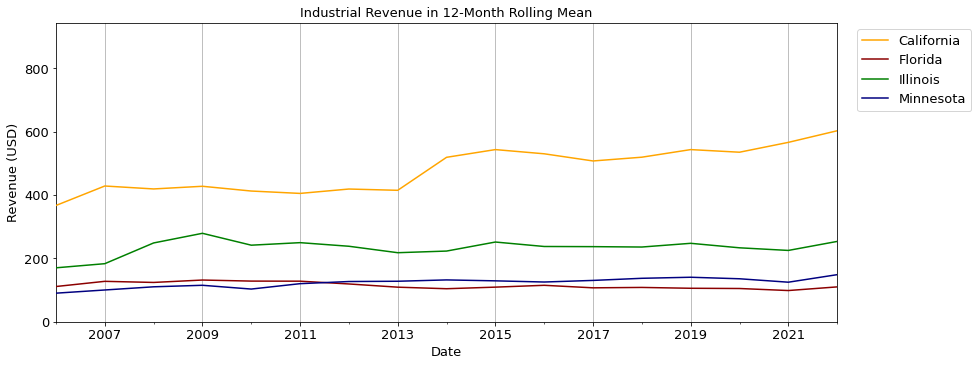

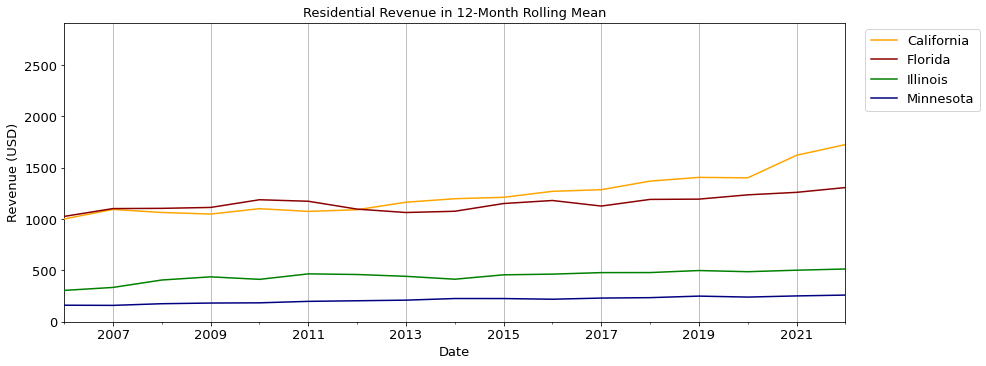

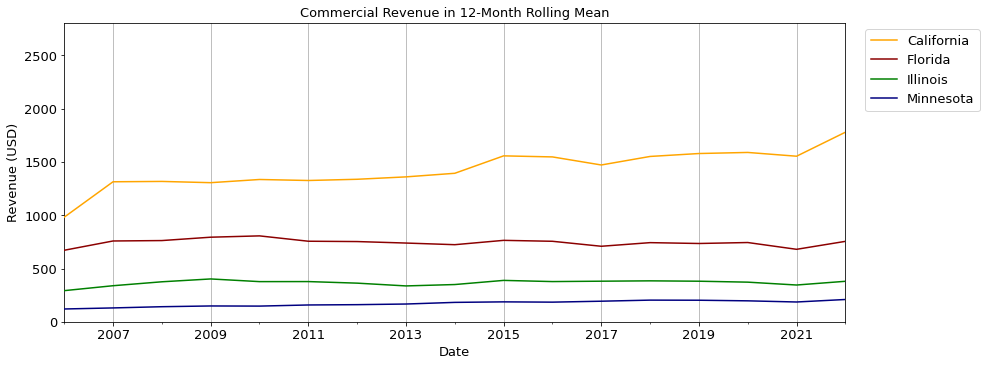

In [448]:
merged_line_byMonth(df_states_ALL, df_ALL_Rev, 'Revenue', '12M', 'Overall')
merged_line_byMonth(df_states_IND, df_IND_Rev, 'Revenue', '12M', 'Industrial')
merged_line_byMonth(df_states_RES, df_RES_Rev, 'Revenue', '12M', 'Residential')
merged_line_byMonth(df_states_COM, df_COM_Rev, 'Revenue', '12M', 'Commercial')

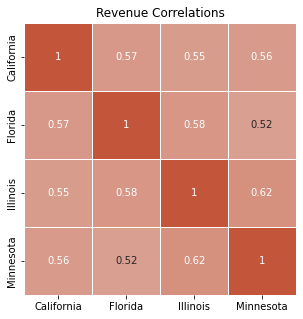

In [467]:
plot_heatmap("Revenue", df_merged_Rev)

## Percantage Analysis

We create a function that compare the variable to the mean of variable in all sectors to see price/sales/revenue in each sectors are high/moderate/low compared to them in all sectors. we'll catogorize the value higher than the mean of max in all sectors as High, between it and higher than mean of median in all sectors as Moderate, others are Low. 

In [516]:
def percentage(df_states, var):
    rows = []
    # create a DataFrame with hourly percentage for different salesfall categories
    for state_name in state_names:
        row = {"Low":0, "Moderate":0, "High":0}
        for i, value in df_states[state_name][var].iteritems():
            if value > compute_stats(df_sectors, var)["Max"].mean():
                row["High"] += 1
            elif value >= compute_stats(df_sectors, var)["Median"].mean():
                row["Moderate"] += 1
            # any sales at all?
            elif value > 0:
                row["Low"] += 1
        # convert numbers to percentages
        for i in row:
            row[i] = (100.0*row[i])/len(df_states[state_name])
        row["State"] = state_name
        rows.append(row)
    df_sales_levels = pd.DataFrame(rows).set_index("State")
    # put the states on columns
    df_sales_levels = df_sales_levels.transpose()
    return df_sales_levels

In [517]:
def per_bar(df_states, var):
    df_levels = percentage(df_states, var)
    ax = df_levels.plot.bar(figsize=(10,5), width=0.6, fontsize=fontsize, color=state_colors, zorder=3)
    ax.legend(fontsize=fontsize)
    ax.set_ylabel("%s Percentage" % var , fontsize=fontsize)
    ax.yaxis.grid(True)
    # adjust the x-axis label rotation
    plt.xticks(rotation=45, ha='right');

This means that generally, electricity price in Illinois are almost 100% low compared to these 4, following by Minnesota, around 90% of time are considered low and 10% of time is moderate, and 70% of time in Florida is low, around 30% is moderate. In California, over 20% of time has expensive price.

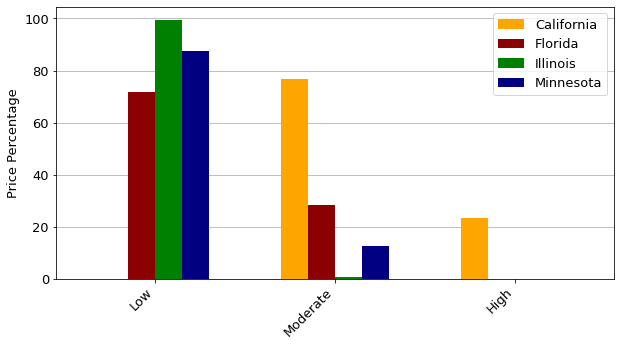

In [518]:
per_bar(df_states_ALL, "Price")

This tells us that industrial price is basically low in all 4 sectors, and California has the most expensive one among these 4 states.

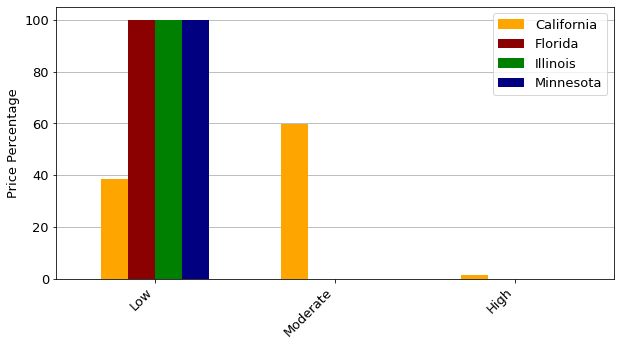

In [519]:
per_bar(df_states_IND, "Price")

Electricity price in residential area is realatively moderate.

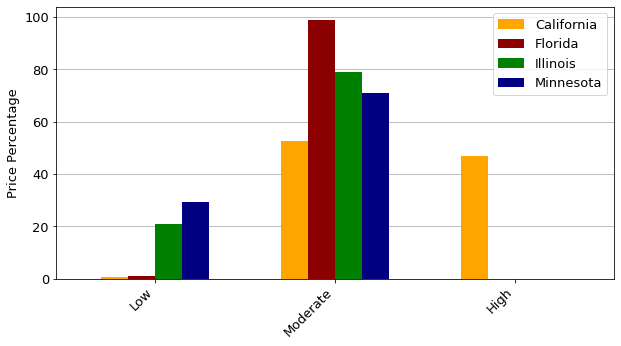

In [498]:
per_bar(df_states_RES, "Price")

Commercial electricity price is relatively low, but a bit higher than it in Industrial area.

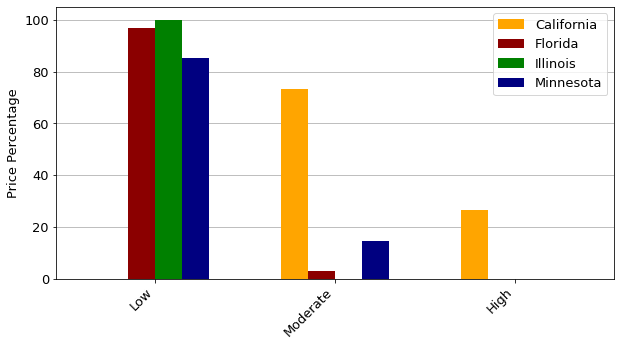

In [499]:
per_bar(df_states_COM, "Price")

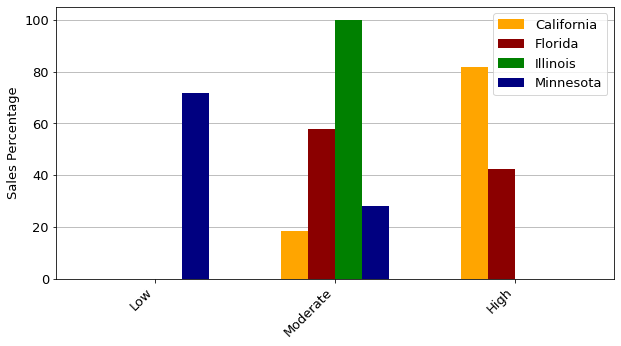

In [501]:
per_bar(df_states_ALL, "Sales")

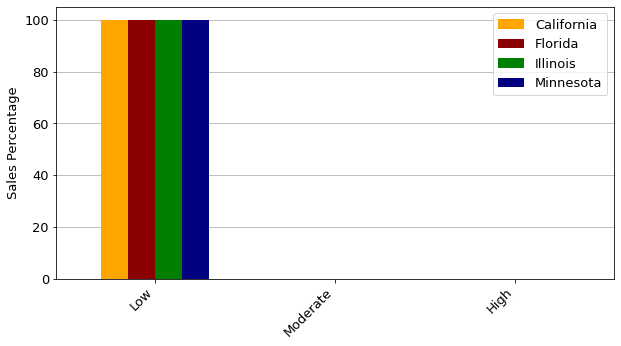

In [502]:
per_bar(df_states_IND, "Sales")

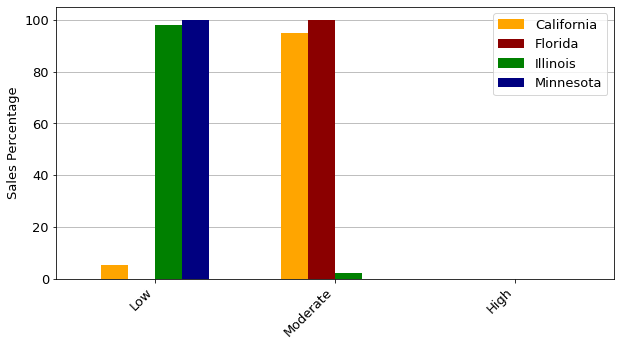

In [503]:
per_bar(df_states_RES, "Sales")

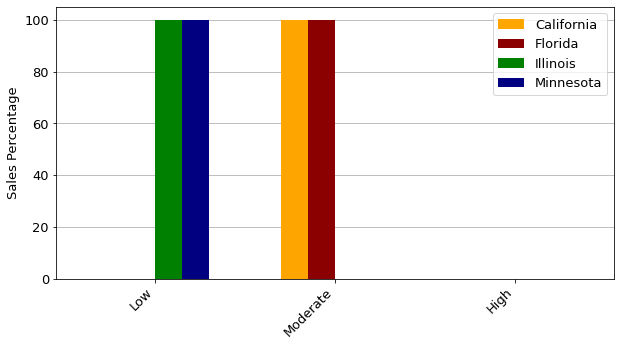

In [504]:
per_bar(df_states_COM, "Sales")

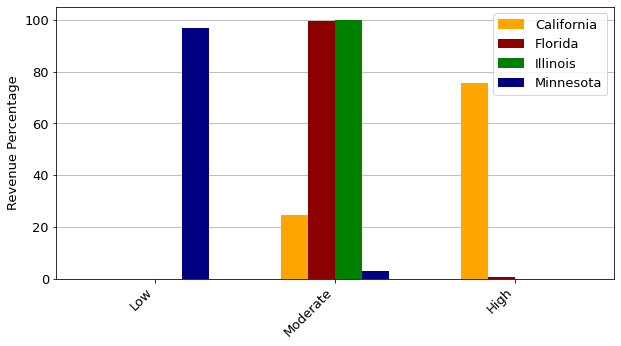

In [505]:
per_bar(df_states_ALL, "Revenue")

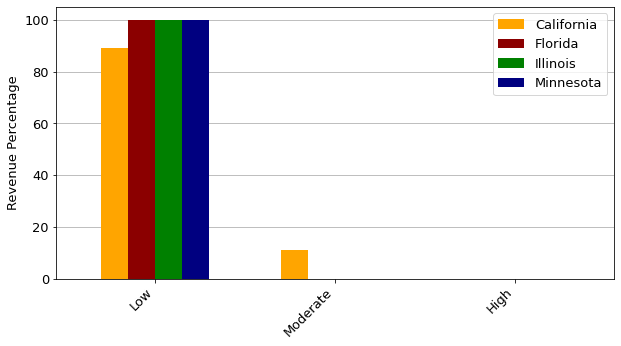

In [506]:
per_bar(df_states_IND, "Revenue")

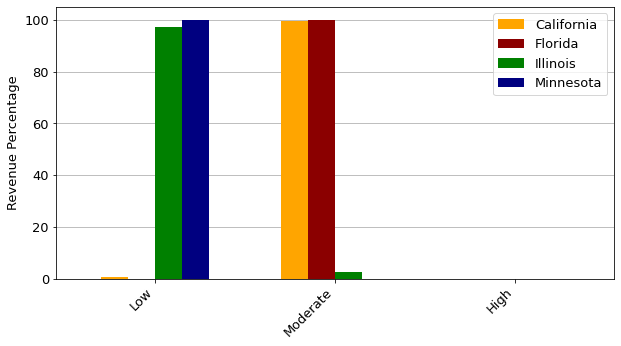

In [507]:
per_bar(df_states_RES, "Revenue")

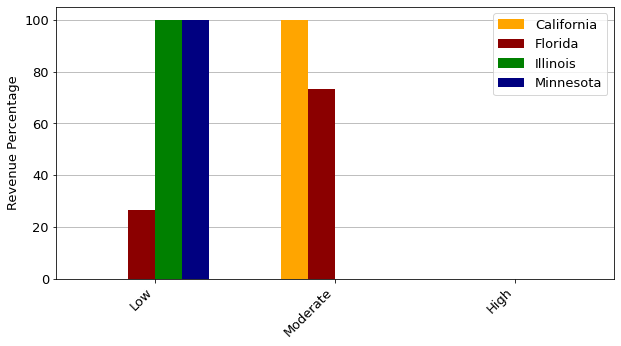

In [508]:
per_bar(df_states_COM, "Revenue")

## Correlations Between Variables

In [352]:
target_columns = ['Price', 'Sales', 'Revenue']

In [359]:
def cor_df(df_states):
    all_dfs = []
    for state_name in state_names:
        all_dfs.append(df_states[state_name].reset_index())
    # concatendate all of the DataFrames into a single stacked frame
    df_all = pd.concat(all_dfs)
    return df_all[target_columns]

In [360]:
cor_ALL = cor_df(df_states_ALL)
cor_IND = cor_df(df_states_IND)
cor_RES = cor_df(df_states_RES)
cor_COM = cor_df(df_states_COM)
cor = cor_df(df_states)

In [371]:
cor_COM.head()

Price       Sales     Revenue
0  10.65  9215.50066   981.88164
1  11.47  8585.65777   984.74646
2  11.34  9720.91324  1101.99226
3  11.85  8348.23042   989.35948
4  12.43  9662.50283  1200.68555

### ALL sector

Let's see the relation between three variables(Price/Sales/Revenue).

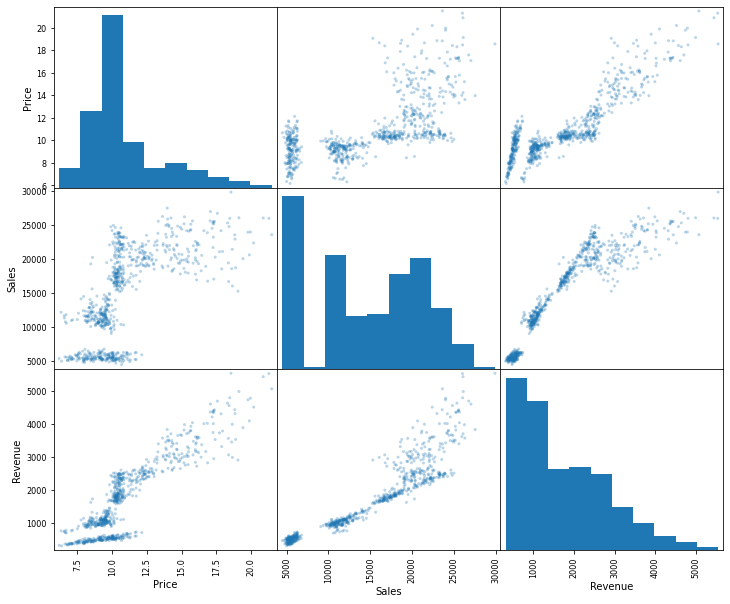

In [362]:
ax = scatter_matrix(cor_ALL, figsize=(12,10), alpha=0.3)

Using heatmap to get a more intuitive look of their relation.

By this, we can tell that Sales and Revenue are highly related, Price and Revenue are so. Comparing to those two just mentioned, Sales and Price are not that related.

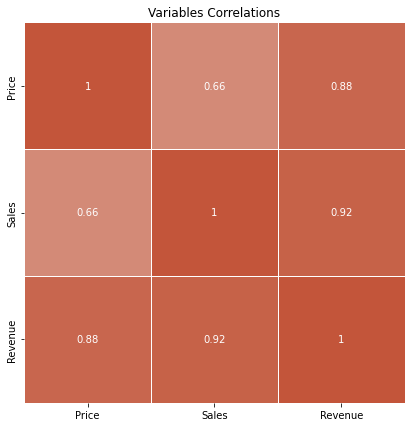

In [367]:
plot_heatmap("Variables", cor_ALL, figsize=(11,7))

### Industrial sector

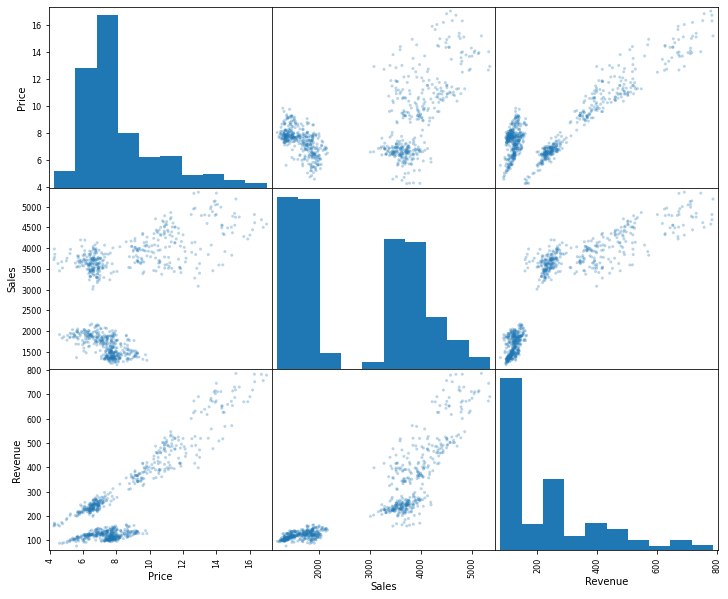

In [364]:
ax = scatter_matrix(cor_IND, figsize=(12,10), alpha=0.3)

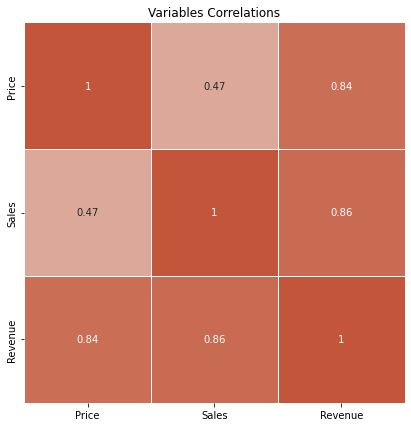

In [368]:
plot_heatmap("Variables", cor_IND, figsize=(11,7))

### Residential sector

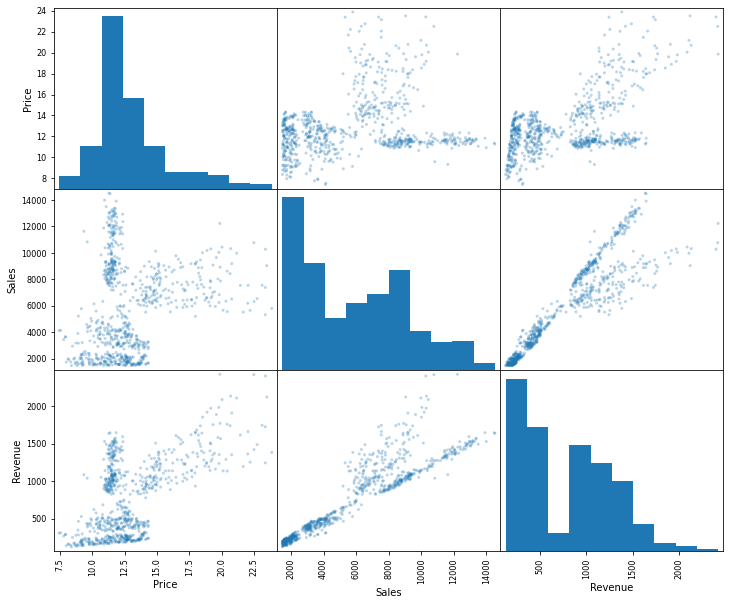

In [365]:
ax = scatter_matrix(cor_RES, figsize=(12,10), alpha=0.3)

This is more obvious in residential area, Sales and Revenue are highly related compared to its Price.

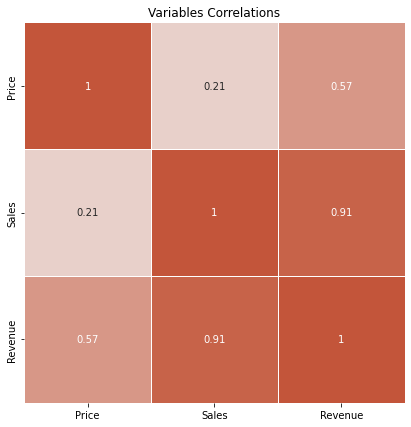

In [369]:
plot_heatmap("Variables", cor_RES, figsize=(11,7))

### Commercial sector

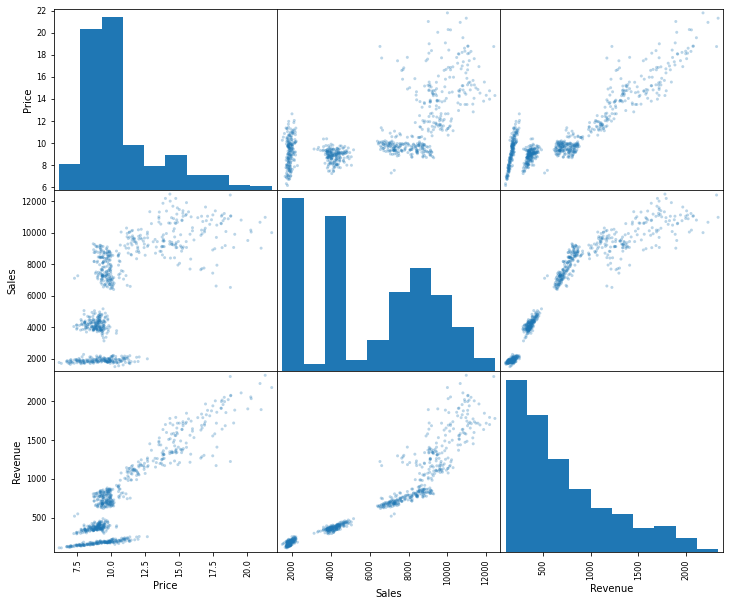

In [366]:
ax = scatter_matrix(cor_COM, figsize=(12,10), alpha=0.3)

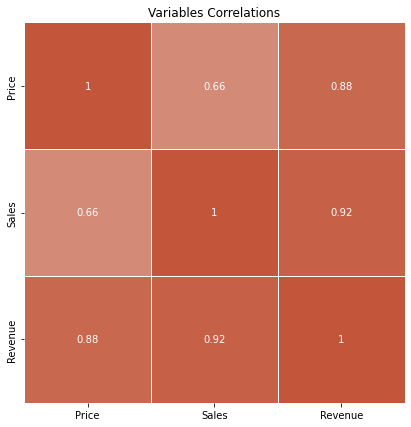

In [370]:
plot_heatmap("Variables", cor_COM, figsize=(11,7))

### All 4 Sectors together

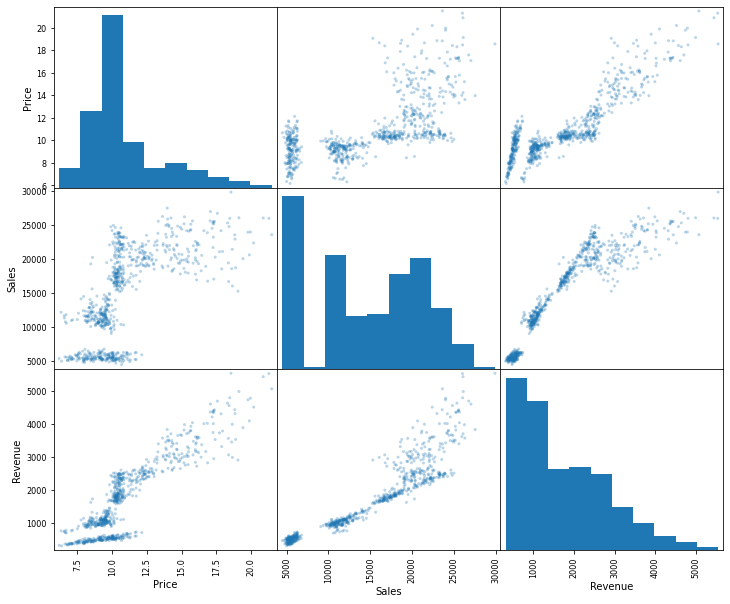

In [472]:
ax = scatter_matrix(cor, figsize=(12,10), alpha=0.3)

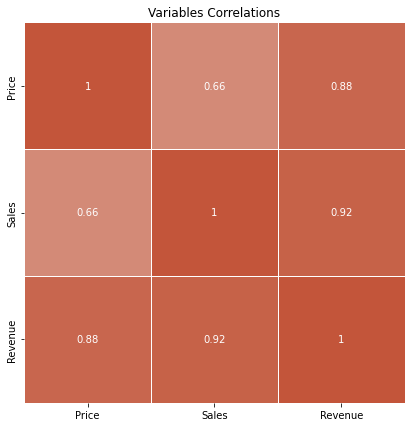

In [473]:
plot_heatmap("Variables", cor, figsize=(11,7))

## Task 3 - Discussion and Conclusions

In this assignment, I collected the monthly electricity selling data for 16 years(2006-2021) in 4 states of the US. The data include price(cents per kilowatthour), revenue(million dollars), sales(million kilowatthours, the electricity price differs from its sector, there are industrial(IND), residential(RES), commercial(COM) and all sectors(ALL) and the 4 states are Califronia(CA), Florida(FL), Illinois(IL) and Minnosota(MN).

We will focus on the difference and relation between four states instead of the sectors in a state over the years. Firstly, we discuss the data by line graphs, bar graphs and box graphs to see the fluctuation and trend of each states, then we use heatmap to show the correlation between four states. Secondly, we use bar chart to see the how low or high the price, sales and revenue are in each sector compared to the average data for the 4 sectors, so we could know the overall/industrial/residential/commercial price/sales/revenue is relatively high or low. Lastly, we put variables(price/sales/revenue) to scatter matrix to see the relation between them, then we use heatmap to get a more intuitive view.

From the analysis, we can tell that California always has the most expensive eletricity price all the time and it fluctuates the most as well. Florida has the most stable price over the years. If we only see line graph, we would say the electricity price in California has changed the most for past 16 years, but if we have a closer look. The electricity price in Minnesota and Illinois are almost double too. We can say this with the help of heat map since it tells us that these three has similar pattern. The sales part has significant fluctuation in some month of a year, but if we see them in a yearly basis, it’s relatively stable compared to price. Revenue slightly goes up over the years in California.


In general, California has the most expensive electricity all the time as expected, also we found out that the price/sales/revenue are also the most unstable.
Some of the challenging part in this assignment are like what frequency of the time period should I get, which sectors of electricity data should I choose from six different sectors in each state, which should I choose from 52 states. So I have to retrieve them first and make an easy version chart to see if they are suitable for this assignment. 


There are some more interesting analysis could be made from this API like what’s the relation between sectors in each state, in what season or what month the electricity price/sales/revenue are the highest and the correlation of each sectors. But it all requires more complexed data processing.
